# TP2 - Aprendizaje Profundo: Solución

### Nombre: Christian Ricardo Conchari Cabrera
### Cohorte: 15Co2024

# Parte 2.a - Implementación de una red neuronal convolucional

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset CIFAR10, las clases `['cat', 'dog', 'frog']`. Entrene solamente usando las clases mencionadas (ver dataset de ejemplo).

Sobre dicho modelo, evalue el comportamiento de la accuracy bajo los siguientes tamaños de `kernel_size = [5, 7, 9, 11]`.

Grafique la evolución de la función de perdida y la accuracy (para train y test) para cada modelo y elija el que considera mejor. En caso de encontrar overfitting, tome las medidas adecuadas.

## Importación de librerias

In [159]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import os
from tqdm import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

Verificar la disponibilidad de cuda

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Generación del dataset

Se define un dataset que solamente contenga las clases seleccionadas.

In [97]:
class FilteredDataset(Dataset):
  def __init__(self, original_dataset, selected_labels):
    """
    Initialize the FilteredDataset with the original dataset and selected labels.

    Parameters:
    - original_dataset: The original dataset.
    - selected_labels: A list of labels to filter the dataset.
    """
    # Store the original dataset and selected labels
    self.original_dataset = original_dataset
    self.selected_labels = selected_labels

    # Create a dictionary to remap selected labels to ascending indices
    self.label_map = {label: idx for idx, label in enumerate(selected_labels)}

    # Filter the indices of the images that belong to the selected classes
    self.indices = [i for i, label in enumerate(original_dataset.targets) if label in selected_labels]

  def __len__(self):
    """
    Get the length of the filtered dataset.

    Returns:
    - The length of the filtered dataset.
    """
    # Return the length of the filtered dataset
    return len(self.indices)

  def __getitem__(self, idx):
    """
    Get an item from the filtered dataset.

    Parameters:
    - idx: The index of the item to retrieve.

    Returns:
    - A tuple containing the image and the remapped label.
    """
    # Get the index of the original dataset
    original_idx = self.indices[idx]

    # Get the corresponding image and label from the original dataset
    image, label = self.original_dataset[original_idx]

    # Remap the label using the label_map dictionary
    remapped_label = self.label_map[label]

    # Return the image and the remapped label
    return image, remapped_label

Definimos las transformaciones que se aplicarán sobre las imágenes

In [98]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

Descargar y cargar el conjunto de datos CIFAR-10

In [99]:
original_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
original_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Se seleccionan 3 clases: gato, perro, rana

In [100]:
classes = original_train_dataset.classes
selected_classes = ['cat', 'dog', 'frog']
selected_class_indices = [classes.index(cls) for cls in selected_classes]

Se creará un nuevo conjunto de datos con las clases seleccionadas

In [101]:
filtered_train_dataset = FilteredDataset(original_train_dataset, selected_class_indices)
filtered_test_dataset = FilteredDataset(original_test_dataset, selected_class_indices)

Se visualiza el tamaño de los conjuntos de datos

In [118]:
print(f'Original train dataset: {len(original_train_dataset)} images')
print(f'Filtered train dataset: {len(filtered_train_dataset)} images')

Original train dataset: 50000 images
Filtered train dataset: 15000 images


In [119]:
print(f'Original test dataset: {len(original_test_dataset)} images')
print(f'Filtered test dataset: {len(filtered_test_dataset)} images')

Original test dataset: 10000 images
Filtered test dataset: 3000 images


Se crean `DataLoaders` para los nuevos datasets con un tamaño de batch de 64

In [102]:
# Define the batch size
batch_size = 16

# Create DataLoaders for the new datasets
trainloader = DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Se define una función para mostrar una imagen



In [205]:
def imshow(img):
  """
  Display an image tensor.

  Parameters:
  - img: The image tensor to display.
  """
  # De-normalize the image
  img = img / 2 + 0.5  
  # Convert the image tensor to a NumPy array
  npimg = img.numpy()  
  # Transpose the dimensions and display the image
  plt.imshow(np.transpose(npimg, (1, 2, 0)))  
  
  plt.grid(False)
  
  plt.show()

Se genera un lote de imágenes y se las muestra

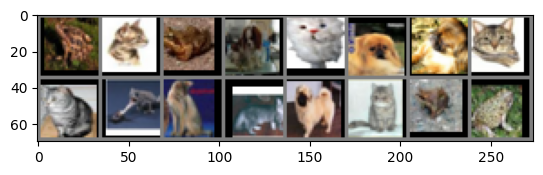

frog cat frog dog cat dog dog cat cat frog cat cat dog cat frog frog


In [104]:
# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display images from the batch
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{selected_classes[labels[j]]}' for j in range(batch_size)))

## Implementación de la arquitectura CNN

En la siguiente celda se define la arquitectura de la red neuronal convolucional que se empleará para los experimentos con diferentes tamaños de kernel.

In [105]:
class CNN(torch.nn.Module):
    def __init__(self, n_classes=3, n_outputs=3, kernel_size=5):
        """
        Initialize the CNN model.
        
        Parameters:
        - n_classes: The number of input channels.
        - n_outputs: The number of output classes.
        - kernel_size: The size of the convolutional kernels.
        """
        super(CNN, self).__init__()

        # Define the convolutional layers
        self.conv1 = torch.nn.Conv2d(n_classes, 64, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu1 = torch.nn.LeakyReLU()
        self.maxpool1 = torch.nn.MaxPool2d((2, 2))

        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn2 = torch.nn.BatchNorm2d(128)
        self.relu2 = torch.nn.LeakyReLU()
        self.maxpool2 = torch.nn.MaxPool2d((2, 2))
        self.dropout2 = torch.nn.Dropout(0.3)

        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn3 = torch.nn.BatchNorm2d(256)
        self.relu3 = torch.nn.LeakyReLU()
        self.maxpool3 = torch.nn.MaxPool2d((2, 2))
        self.dropout3 = torch.nn.Dropout(0.3)

        self.conv4 = torch.nn.Conv2d(256, 256, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn4 = torch.nn.BatchNorm2d(256)
        self.relu4 = torch.nn.LeakyReLU()
        self.maxpool4 = torch.nn.MaxPool2d((2, 2))
        self.dropout4 = torch.nn.Dropout(0.3)

        # Define the global average pooling layer
        self.gap = torch.nn.AdaptiveAvgPool2d((1, 1))

        # Define the fully-connected layers
        self.linear = torch.nn.Linear(256, 64)
        self.dropout5 = torch.nn.Dropout(0.4)
        self.relu5 = torch.nn.LeakyReLU()
        self.linear2 = torch.nn.Linear(64, n_outputs)
        
    def forward(self, x):
        """
        Forward pass of the CNN model.
        
        Parameters:
        - x: The input image batch.
        
        Returns:
        - The output of the CNN model.
        """
        # Apply the convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x)

        # Apply the global average pooling layer
        x = self.gap(x)

        # Flatten the output of the convolutional layers
        x = x.view(x.size(0), -1)
        
        # Apply the fully-connected layers
        x = self.linear(x)
        x = self.relu5(x)
        x = self.dropout5(x)
        x = self.linear2(x)

        return x

Se muestra la arquitectura de la red neuronal convolucional que se implementará

In [106]:
model = CNN()

model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]         204,928
       BatchNorm2d-6          [-1, 128, 16, 16]             256
         LeakyReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
           Dropout-9            [-1, 128, 8, 8]               0
           Conv2d-10            [-1, 256, 8, 8]         819,456
      BatchNorm2d-11            [-1, 256, 8, 8]             512
        LeakyReLU-12            [-1, 256, 8, 8]               0
        MaxPool2d-13            [-1, 256, 4, 4]               0
          Dropout-14            [-1, 25

Se define la función de entrenamiento

In [109]:
def fit(model, dataloader, epochs=15):
    """
    Train the model using the given data.
    
    Parameters:
    - model: The model to train.
    - dataloader: The DataLoader object containing the training data.
    - epochs: The number of epochs for training.
    
    Returns:
    - A dictionary containing the training and validation metrics.
    """
    # Move the model to the device
    model.to(device)
    
    # Define the optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    criterion = torch.nn.CrossEntropyLoss()

    # Lists to store the metrics for each epoch
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []

    for epoch in range(1, epochs+1):
        # Set the model to train mode
        model.train()
        
        # Initialize the training loss and number of correct predictions
        train_loss = []
        train_acc = []

        for batch in tqdm(dataloader['train'], desc=f"Training Epoch {epoch}/{epochs}"):
            # Get the input data and move it to the device
            X, y = batch
            X, y = X.to(device), y.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            y_hat = model(X)
            
            # Calculate the loss
            loss = criterion(y_hat, y)
            
            # Backward pass
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Store the loss and accuracy for this batch
            train_loss.append(loss.item())
            acc = (y_hat.argmax(dim=1) == y).sum().item() / len(y)
            train_acc.append(acc)

        # Calculate and store the average training loss and accuracy for this epoch
        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_train_acc = sum(train_acc) / len(train_acc)
        epoch_t_loss.append(avg_train_loss)
        epoch_t_acc.append(avg_train_acc)

        # Set the model to evaluation mode
        model.eval()
        
        # Initialize the validation loss and number of correct predictions
        val_loss = []
        val_acc = []

        # Disable gradient computation
        with torch.no_grad():
            for batch in tqdm(dataloader['test'], desc="Validating", leave=False):
                # Get the input data and move it to the device
                X, y = batch
                X, y = X.to(device), y.to(device)
                
                # Forward pass
                y_hat = model(X)
                
                # Calculate the loss
                loss = criterion(y_hat, y)
                
                # Store the loss and accuracy for this batch
                val_loss.append(loss.item())
                acc = (y_hat.argmax(dim=1) == y).sum().item() / len(y)
                val_acc.append(acc)

        # Calculate and store the average validation loss and accuracy for this epoch
        avg_val_loss = sum(val_loss) / len(val_loss)
        avg_val_acc = sum(val_acc) / len(val_acc)
        epoch_v_loss.append(avg_val_loss)
        epoch_v_acc.append(avg_val_acc)

        # Print the summary after each epoch
        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")

    return {
        'train_loss': epoch_t_loss,
        'val_loss': epoch_v_loss,
        'train_acc': epoch_t_acc,
        'val_acc': epoch_v_acc
    }

En las siguientes secciones, se entrenará el modelo con diferentes tamaños de kernel y se evaluará su desempeño. La arquitectura seleccionada fue construida después de realizar varios experimentos y probar distintas medidas para mitigar el overfitting. El modelo final es el que se describe a continuación.

Para mitigar el overfitting, se tomaron las siguientes medidas:

- **Aumento de datos:** Se implementaron transformaciones como `transforms.RandomHorizontalFlip()` y `transforms.RandomCrop(32, padding=4)` para aumentar la cantidad de datos de entrenamiento y mejorar la capacidad de generalización del modelo.
- **Regularización:** Se añadieron capas de dropout en las capas convolucionales y en la primera capa lineal del modelo para prevenir el sobreajuste.
- **Weight decay:** Se utilizó un valor de `weight_decay=1e-3` en el optimizador para penalizar los pesos grandes.

Adicionalmente, se experimentó con diferentes valores de `learning_rate` y `batch_size` para optimizar el rendimiento del modelo. Los valores que ofrecieron mejores resultados fueron `learning_rate=1e-4` y `batch_size=16`, los cuales se emplearán en los experimentos siguientes.

## Experimento con tamaño de kernel 5x5

A continuación, se entrenará el modelo partiendo con el `kernel_size=5` y se evaluará su comportamiento en términos de la pérdida y *accuracy*.

In [110]:
model = CNN()
history = fit(model, {'train': trainloader, 'test': testloader}, epochs=100)

Training Epoch 1/100:   0%|          | 0/938 [00:00<?, ?it/s]

Training Epoch 1/100: 100%|██████████| 938/938 [00:05<00:00, 185.02it/s]


Epoch 1/100 | Train Loss: 0.8706 | Train Acc: 0.5681 | Val Loss: 0.7647 | Val Acc: 0.6330


Training Epoch 2/100: 100%|██████████| 938/938 [00:04<00:00, 195.18it/s]


Epoch 2/100 | Train Loss: 0.7629 | Train Acc: 0.6354 | Val Loss: 0.7211 | Val Acc: 0.6559


Training Epoch 3/100: 100%|██████████| 938/938 [00:04<00:00, 198.07it/s]


Epoch 3/100 | Train Loss: 0.7255 | Train Acc: 0.6656 | Val Loss: 0.6637 | Val Acc: 0.6928


Training Epoch 4/100: 100%|██████████| 938/938 [00:04<00:00, 202.08it/s]


Epoch 4/100 | Train Loss: 0.6839 | Train Acc: 0.6888 | Val Loss: 0.6175 | Val Acc: 0.7274


Training Epoch 5/100: 100%|██████████| 938/938 [00:04<00:00, 195.88it/s]


Epoch 5/100 | Train Loss: 0.6625 | Train Acc: 0.7009 | Val Loss: 0.6635 | Val Acc: 0.6852


Training Epoch 6/100: 100%|██████████| 938/938 [00:04<00:00, 202.15it/s]


Epoch 6/100 | Train Loss: 0.6318 | Train Acc: 0.7193 | Val Loss: 0.5772 | Val Acc: 0.7414


Training Epoch 7/100: 100%|██████████| 938/938 [00:04<00:00, 205.40it/s]


Epoch 7/100 | Train Loss: 0.6060 | Train Acc: 0.7318 | Val Loss: 0.5726 | Val Acc: 0.7490


Training Epoch 8/100: 100%|██████████| 938/938 [00:04<00:00, 203.17it/s]


Epoch 8/100 | Train Loss: 0.5932 | Train Acc: 0.7429 | Val Loss: 0.5469 | Val Acc: 0.7673


Training Epoch 9/100: 100%|██████████| 938/938 [00:04<00:00, 201.18it/s]


Epoch 9/100 | Train Loss: 0.5742 | Train Acc: 0.7461 | Val Loss: 0.5329 | Val Acc: 0.7620


Training Epoch 10/100: 100%|██████████| 938/938 [00:04<00:00, 204.04it/s]


Epoch 10/100 | Train Loss: 0.5467 | Train Acc: 0.7645 | Val Loss: 0.5028 | Val Acc: 0.7689


Training Epoch 11/100: 100%|██████████| 938/938 [00:04<00:00, 204.61it/s]


Epoch 11/100 | Train Loss: 0.5456 | Train Acc: 0.7679 | Val Loss: 0.5246 | Val Acc: 0.7666


Training Epoch 12/100: 100%|██████████| 938/938 [00:04<00:00, 201.92it/s]


Epoch 12/100 | Train Loss: 0.5290 | Train Acc: 0.7728 | Val Loss: 0.4719 | Val Acc: 0.7906


Training Epoch 13/100: 100%|██████████| 938/938 [00:04<00:00, 203.96it/s]


Epoch 13/100 | Train Loss: 0.5146 | Train Acc: 0.7797 | Val Loss: 0.4784 | Val Acc: 0.7922


Training Epoch 14/100: 100%|██████████| 938/938 [00:04<00:00, 206.96it/s]


Epoch 14/100 | Train Loss: 0.5113 | Train Acc: 0.7820 | Val Loss: 0.5008 | Val Acc: 0.7829


Training Epoch 15/100: 100%|██████████| 938/938 [00:04<00:00, 201.73it/s]


Epoch 15/100 | Train Loss: 0.4991 | Train Acc: 0.7882 | Val Loss: 0.4629 | Val Acc: 0.7939


Training Epoch 16/100: 100%|██████████| 938/938 [00:04<00:00, 202.42it/s]


Epoch 16/100 | Train Loss: 0.4916 | Train Acc: 0.7956 | Val Loss: 0.4906 | Val Acc: 0.7989


Training Epoch 17/100: 100%|██████████| 938/938 [00:05<00:00, 167.22it/s]


Epoch 17/100 | Train Loss: 0.4824 | Train Acc: 0.7961 | Val Loss: 0.4916 | Val Acc: 0.7849


Training Epoch 18/100: 100%|██████████| 938/938 [00:05<00:00, 162.02it/s]


Epoch 18/100 | Train Loss: 0.4714 | Train Acc: 0.8026 | Val Loss: 0.4415 | Val Acc: 0.8068


Training Epoch 19/100: 100%|██████████| 938/938 [00:05<00:00, 159.49it/s]


Epoch 19/100 | Train Loss: 0.4678 | Train Acc: 0.8013 | Val Loss: 0.4713 | Val Acc: 0.8009


Training Epoch 20/100: 100%|██████████| 938/938 [00:05<00:00, 164.24it/s]


Epoch 20/100 | Train Loss: 0.4618 | Train Acc: 0.8050 | Val Loss: 0.4375 | Val Acc: 0.8142


Training Epoch 21/100: 100%|██████████| 938/938 [00:05<00:00, 166.46it/s]


Epoch 21/100 | Train Loss: 0.4559 | Train Acc: 0.8098 | Val Loss: 0.4494 | Val Acc: 0.8078


Training Epoch 22/100: 100%|██████████| 938/938 [00:05<00:00, 165.31it/s]


Epoch 22/100 | Train Loss: 0.4530 | Train Acc: 0.8101 | Val Loss: 0.4479 | Val Acc: 0.8112


Training Epoch 23/100: 100%|██████████| 938/938 [00:05<00:00, 171.11it/s]


Epoch 23/100 | Train Loss: 0.4421 | Train Acc: 0.8140 | Val Loss: 0.4187 | Val Acc: 0.8195


Training Epoch 24/100: 100%|██████████| 938/938 [00:05<00:00, 171.68it/s]


Epoch 24/100 | Train Loss: 0.4326 | Train Acc: 0.8196 | Val Loss: 0.4174 | Val Acc: 0.8298


Training Epoch 25/100: 100%|██████████| 938/938 [00:05<00:00, 171.10it/s]


Epoch 25/100 | Train Loss: 0.4374 | Train Acc: 0.8187 | Val Loss: 0.4025 | Val Acc: 0.8308


Training Epoch 26/100: 100%|██████████| 938/938 [00:05<00:00, 167.42it/s]


Epoch 26/100 | Train Loss: 0.4249 | Train Acc: 0.8199 | Val Loss: 0.4124 | Val Acc: 0.8221


Training Epoch 27/100: 100%|██████████| 938/938 [00:04<00:00, 203.10it/s]


Epoch 27/100 | Train Loss: 0.4190 | Train Acc: 0.8298 | Val Loss: 0.4092 | Val Acc: 0.8205


Training Epoch 28/100: 100%|██████████| 938/938 [00:05<00:00, 173.23it/s]


Epoch 28/100 | Train Loss: 0.4165 | Train Acc: 0.8282 | Val Loss: 0.4019 | Val Acc: 0.8348


Training Epoch 29/100: 100%|██████████| 938/938 [00:05<00:00, 171.42it/s]


Epoch 29/100 | Train Loss: 0.4146 | Train Acc: 0.8278 | Val Loss: 0.4231 | Val Acc: 0.8285


Training Epoch 30/100: 100%|██████████| 938/938 [00:05<00:00, 167.52it/s]


Epoch 30/100 | Train Loss: 0.4055 | Train Acc: 0.8317 | Val Loss: 0.3931 | Val Acc: 0.8321


Training Epoch 31/100: 100%|██████████| 938/938 [00:05<00:00, 167.38it/s]


Epoch 31/100 | Train Loss: 0.3992 | Train Acc: 0.8373 | Val Loss: 0.4356 | Val Acc: 0.8175


Training Epoch 32/100: 100%|██████████| 938/938 [00:05<00:00, 168.21it/s]


Epoch 32/100 | Train Loss: 0.3930 | Train Acc: 0.8415 | Val Loss: 0.3859 | Val Acc: 0.8364


Training Epoch 33/100: 100%|██████████| 938/938 [00:04<00:00, 199.17it/s]


Epoch 33/100 | Train Loss: 0.4005 | Train Acc: 0.8370 | Val Loss: 0.4372 | Val Acc: 0.8231


Training Epoch 34/100: 100%|██████████| 938/938 [00:04<00:00, 196.92it/s]


Epoch 34/100 | Train Loss: 0.3889 | Train Acc: 0.8393 | Val Loss: 0.4246 | Val Acc: 0.8231


Training Epoch 35/100: 100%|██████████| 938/938 [00:04<00:00, 201.19it/s]


Epoch 35/100 | Train Loss: 0.3881 | Train Acc: 0.8359 | Val Loss: 0.3956 | Val Acc: 0.8328


Training Epoch 36/100: 100%|██████████| 938/938 [00:04<00:00, 196.80it/s]


Epoch 36/100 | Train Loss: 0.3778 | Train Acc: 0.8495 | Val Loss: 0.3744 | Val Acc: 0.8404


Training Epoch 37/100: 100%|██████████| 938/938 [00:04<00:00, 202.57it/s]


Epoch 37/100 | Train Loss: 0.3745 | Train Acc: 0.8471 | Val Loss: 0.3697 | Val Acc: 0.8514


Training Epoch 38/100: 100%|██████████| 938/938 [00:04<00:00, 205.19it/s]


Epoch 38/100 | Train Loss: 0.3669 | Train Acc: 0.8532 | Val Loss: 0.3876 | Val Acc: 0.8438


Training Epoch 39/100: 100%|██████████| 938/938 [00:04<00:00, 205.96it/s]


Epoch 39/100 | Train Loss: 0.3686 | Train Acc: 0.8517 | Val Loss: 0.3654 | Val Acc: 0.8447


Training Epoch 40/100: 100%|██████████| 938/938 [00:04<00:00, 195.58it/s]


Epoch 40/100 | Train Loss: 0.3684 | Train Acc: 0.8517 | Val Loss: 0.3627 | Val Acc: 0.8491


Training Epoch 41/100: 100%|██████████| 938/938 [00:04<00:00, 195.03it/s]


Epoch 41/100 | Train Loss: 0.3617 | Train Acc: 0.8545 | Val Loss: 0.3842 | Val Acc: 0.8391


Training Epoch 42/100: 100%|██████████| 938/938 [00:05<00:00, 187.35it/s]


Epoch 42/100 | Train Loss: 0.3551 | Train Acc: 0.8519 | Val Loss: 0.3737 | Val Acc: 0.8494


Training Epoch 43/100: 100%|██████████| 938/938 [00:04<00:00, 203.25it/s]


Epoch 43/100 | Train Loss: 0.3550 | Train Acc: 0.8575 | Val Loss: 0.3645 | Val Acc: 0.8517


Training Epoch 44/100: 100%|██████████| 938/938 [00:04<00:00, 198.03it/s]


Epoch 44/100 | Train Loss: 0.3461 | Train Acc: 0.8621 | Val Loss: 0.3735 | Val Acc: 0.8494


Training Epoch 45/100: 100%|██████████| 938/938 [00:04<00:00, 206.05it/s]


Epoch 45/100 | Train Loss: 0.3419 | Train Acc: 0.8611 | Val Loss: 0.3779 | Val Acc: 0.8511


Training Epoch 46/100: 100%|██████████| 938/938 [00:04<00:00, 191.14it/s]


Epoch 46/100 | Train Loss: 0.3403 | Train Acc: 0.8614 | Val Loss: 0.3793 | Val Acc: 0.8431


Training Epoch 47/100: 100%|██████████| 938/938 [00:04<00:00, 204.35it/s]


Epoch 47/100 | Train Loss: 0.3411 | Train Acc: 0.8635 | Val Loss: 0.3548 | Val Acc: 0.8534


Training Epoch 48/100: 100%|██████████| 938/938 [00:04<00:00, 202.60it/s]


Epoch 48/100 | Train Loss: 0.3412 | Train Acc: 0.8614 | Val Loss: 0.3947 | Val Acc: 0.8404


Training Epoch 49/100: 100%|██████████| 938/938 [00:04<00:00, 200.32it/s]


Epoch 49/100 | Train Loss: 0.3295 | Train Acc: 0.8661 | Val Loss: 0.3547 | Val Acc: 0.8584


Training Epoch 50/100: 100%|██████████| 938/938 [00:04<00:00, 205.26it/s]


Epoch 50/100 | Train Loss: 0.3236 | Train Acc: 0.8711 | Val Loss: 0.3876 | Val Acc: 0.8501


Training Epoch 51/100: 100%|██████████| 938/938 [00:04<00:00, 204.43it/s]


Epoch 51/100 | Train Loss: 0.3238 | Train Acc: 0.8705 | Val Loss: 0.4332 | Val Acc: 0.8278


Training Epoch 52/100: 100%|██████████| 938/938 [00:04<00:00, 204.53it/s]


Epoch 52/100 | Train Loss: 0.3267 | Train Acc: 0.8678 | Val Loss: 0.3723 | Val Acc: 0.8501


Training Epoch 53/100: 100%|██████████| 938/938 [00:04<00:00, 204.82it/s]


Epoch 53/100 | Train Loss: 0.3173 | Train Acc: 0.8737 | Val Loss: 0.3658 | Val Acc: 0.8471


Training Epoch 54/100: 100%|██████████| 938/938 [00:04<00:00, 197.54it/s]


Epoch 54/100 | Train Loss: 0.3166 | Train Acc: 0.8764 | Val Loss: 0.3518 | Val Acc: 0.8567


Training Epoch 55/100: 100%|██████████| 938/938 [00:04<00:00, 206.65it/s]


Epoch 55/100 | Train Loss: 0.3123 | Train Acc: 0.8757 | Val Loss: 0.3517 | Val Acc: 0.8507


Training Epoch 56/100: 100%|██████████| 938/938 [00:04<00:00, 205.25it/s]


Epoch 56/100 | Train Loss: 0.3122 | Train Acc: 0.8755 | Val Loss: 0.3469 | Val Acc: 0.8570


Training Epoch 57/100: 100%|██████████| 938/938 [00:04<00:00, 203.70it/s]


Epoch 57/100 | Train Loss: 0.3112 | Train Acc: 0.8753 | Val Loss: 0.3632 | Val Acc: 0.8484


Training Epoch 58/100: 100%|██████████| 938/938 [00:04<00:00, 206.60it/s]


Epoch 58/100 | Train Loss: 0.3035 | Train Acc: 0.8787 | Val Loss: 0.3379 | Val Acc: 0.8590


Training Epoch 59/100: 100%|██████████| 938/938 [00:04<00:00, 201.87it/s]


Epoch 59/100 | Train Loss: 0.3059 | Train Acc: 0.8748 | Val Loss: 0.3557 | Val Acc: 0.8541


Training Epoch 60/100: 100%|██████████| 938/938 [00:04<00:00, 201.15it/s]


Epoch 60/100 | Train Loss: 0.3019 | Train Acc: 0.8815 | Val Loss: 0.3353 | Val Acc: 0.8627


Training Epoch 61/100: 100%|██████████| 938/938 [00:04<00:00, 203.37it/s]


Epoch 61/100 | Train Loss: 0.2998 | Train Acc: 0.8808 | Val Loss: 0.3531 | Val Acc: 0.8531


Training Epoch 62/100: 100%|██████████| 938/938 [00:04<00:00, 193.35it/s]


Epoch 62/100 | Train Loss: 0.2938 | Train Acc: 0.8839 | Val Loss: 0.3317 | Val Acc: 0.8620


Training Epoch 63/100: 100%|██████████| 938/938 [00:04<00:00, 197.54it/s]


Epoch 63/100 | Train Loss: 0.2882 | Train Acc: 0.8859 | Val Loss: 0.3715 | Val Acc: 0.8521


Training Epoch 64/100: 100%|██████████| 938/938 [00:04<00:00, 204.89it/s]


Epoch 64/100 | Train Loss: 0.2926 | Train Acc: 0.8838 | Val Loss: 0.3486 | Val Acc: 0.8570


Training Epoch 65/100: 100%|██████████| 938/938 [00:04<00:00, 205.05it/s]


Epoch 65/100 | Train Loss: 0.2821 | Train Acc: 0.8882 | Val Loss: 0.3457 | Val Acc: 0.8584


Training Epoch 66/100: 100%|██████████| 938/938 [00:04<00:00, 199.42it/s]


Epoch 66/100 | Train Loss: 0.2855 | Train Acc: 0.8875 | Val Loss: 0.3369 | Val Acc: 0.8617


Training Epoch 67/100: 100%|██████████| 938/938 [00:04<00:00, 201.99it/s]


Epoch 67/100 | Train Loss: 0.2822 | Train Acc: 0.8877 | Val Loss: 0.3463 | Val Acc: 0.8607


Training Epoch 68/100: 100%|██████████| 938/938 [00:04<00:00, 201.86it/s]


Epoch 68/100 | Train Loss: 0.2763 | Train Acc: 0.8899 | Val Loss: 0.3587 | Val Acc: 0.8604


Training Epoch 69/100: 100%|██████████| 938/938 [00:04<00:00, 203.54it/s]


Epoch 69/100 | Train Loss: 0.2849 | Train Acc: 0.8879 | Val Loss: 0.3374 | Val Acc: 0.8680


Training Epoch 70/100: 100%|██████████| 938/938 [00:04<00:00, 202.01it/s]


Epoch 70/100 | Train Loss: 0.2719 | Train Acc: 0.8944 | Val Loss: 0.3636 | Val Acc: 0.8501


Training Epoch 71/100: 100%|██████████| 938/938 [00:04<00:00, 194.51it/s]


Epoch 71/100 | Train Loss: 0.2721 | Train Acc: 0.8939 | Val Loss: 0.3324 | Val Acc: 0.8634


Training Epoch 72/100: 100%|██████████| 938/938 [00:04<00:00, 200.66it/s]


Epoch 72/100 | Train Loss: 0.2678 | Train Acc: 0.8941 | Val Loss: 0.3577 | Val Acc: 0.8524


Training Epoch 73/100: 100%|██████████| 938/938 [00:04<00:00, 198.55it/s]


Epoch 73/100 | Train Loss: 0.2671 | Train Acc: 0.8973 | Val Loss: 0.3282 | Val Acc: 0.8667


Training Epoch 74/100: 100%|██████████| 938/938 [00:04<00:00, 200.83it/s]


Epoch 74/100 | Train Loss: 0.2657 | Train Acc: 0.8951 | Val Loss: 0.3223 | Val Acc: 0.8727


Training Epoch 75/100: 100%|██████████| 938/938 [00:04<00:00, 198.40it/s]


Epoch 75/100 | Train Loss: 0.2723 | Train Acc: 0.8939 | Val Loss: 0.3441 | Val Acc: 0.8604


Training Epoch 76/100: 100%|██████████| 938/938 [00:04<00:00, 197.52it/s]


Epoch 76/100 | Train Loss: 0.2647 | Train Acc: 0.8972 | Val Loss: 0.3161 | Val Acc: 0.8700


Training Epoch 77/100: 100%|██████████| 938/938 [00:04<00:00, 206.98it/s]


Epoch 77/100 | Train Loss: 0.2569 | Train Acc: 0.8995 | Val Loss: 0.3404 | Val Acc: 0.8604


Training Epoch 78/100: 100%|██████████| 938/938 [00:04<00:00, 205.26it/s]


Epoch 78/100 | Train Loss: 0.2569 | Train Acc: 0.8974 | Val Loss: 0.3316 | Val Acc: 0.8687


Training Epoch 79/100: 100%|██████████| 938/938 [00:04<00:00, 203.31it/s]


Epoch 79/100 | Train Loss: 0.2553 | Train Acc: 0.8985 | Val Loss: 0.3325 | Val Acc: 0.8640


Training Epoch 80/100: 100%|██████████| 938/938 [00:04<00:00, 203.12it/s]


Epoch 80/100 | Train Loss: 0.2481 | Train Acc: 0.9046 | Val Loss: 0.3323 | Val Acc: 0.8693


Training Epoch 81/100: 100%|██████████| 938/938 [00:04<00:00, 197.16it/s]


Epoch 81/100 | Train Loss: 0.2503 | Train Acc: 0.9020 | Val Loss: 0.3414 | Val Acc: 0.8693


Training Epoch 82/100: 100%|██████████| 938/938 [00:05<00:00, 175.00it/s]


Epoch 82/100 | Train Loss: 0.2458 | Train Acc: 0.9039 | Val Loss: 0.3761 | Val Acc: 0.8527


Training Epoch 83/100: 100%|██████████| 938/938 [00:05<00:00, 168.78it/s]


Epoch 83/100 | Train Loss: 0.2484 | Train Acc: 0.9033 | Val Loss: 0.3229 | Val Acc: 0.8693


Training Epoch 84/100: 100%|██████████| 938/938 [00:05<00:00, 160.08it/s]


Epoch 84/100 | Train Loss: 0.2511 | Train Acc: 0.9050 | Val Loss: 0.3221 | Val Acc: 0.8700


Training Epoch 85/100: 100%|██████████| 938/938 [00:05<00:00, 177.33it/s]


Epoch 85/100 | Train Loss: 0.2453 | Train Acc: 0.9048 | Val Loss: 0.3312 | Val Acc: 0.8707


Training Epoch 86/100: 100%|██████████| 938/938 [00:05<00:00, 168.13it/s]


Epoch 86/100 | Train Loss: 0.2419 | Train Acc: 0.9059 | Val Loss: 0.3156 | Val Acc: 0.8697


Training Epoch 87/100: 100%|██████████| 938/938 [00:05<00:00, 169.09it/s]


Epoch 87/100 | Train Loss: 0.2439 | Train Acc: 0.9056 | Val Loss: 0.3436 | Val Acc: 0.8624


Training Epoch 88/100: 100%|██████████| 938/938 [00:05<00:00, 173.40it/s]


Epoch 88/100 | Train Loss: 0.2422 | Train Acc: 0.9047 | Val Loss: 0.3391 | Val Acc: 0.8644


Training Epoch 89/100: 100%|██████████| 938/938 [00:05<00:00, 163.79it/s]


Epoch 89/100 | Train Loss: 0.2378 | Train Acc: 0.9076 | Val Loss: 0.3234 | Val Acc: 0.8757


Training Epoch 90/100: 100%|██████████| 938/938 [00:04<00:00, 202.95it/s]


Epoch 90/100 | Train Loss: 0.2316 | Train Acc: 0.9106 | Val Loss: 0.3263 | Val Acc: 0.8713


Training Epoch 91/100: 100%|██████████| 938/938 [00:05<00:00, 167.80it/s]


Epoch 91/100 | Train Loss: 0.2318 | Train Acc: 0.9114 | Val Loss: 0.3327 | Val Acc: 0.8680


Training Epoch 92/100: 100%|██████████| 938/938 [00:05<00:00, 166.60it/s]


Epoch 92/100 | Train Loss: 0.2336 | Train Acc: 0.9102 | Val Loss: 0.3314 | Val Acc: 0.8747


Training Epoch 93/100: 100%|██████████| 938/938 [00:05<00:00, 173.35it/s]


Epoch 93/100 | Train Loss: 0.2301 | Train Acc: 0.9120 | Val Loss: 0.3254 | Val Acc: 0.8710


Training Epoch 94/100: 100%|██████████| 938/938 [00:05<00:00, 167.32it/s]


Epoch 94/100 | Train Loss: 0.2226 | Train Acc: 0.9122 | Val Loss: 0.3051 | Val Acc: 0.8803


Training Epoch 95/100: 100%|██████████| 938/938 [00:05<00:00, 172.22it/s]


Epoch 95/100 | Train Loss: 0.2227 | Train Acc: 0.9148 | Val Loss: 0.3490 | Val Acc: 0.8630


Training Epoch 96/100: 100%|██████████| 938/938 [00:04<00:00, 189.92it/s]


Epoch 96/100 | Train Loss: 0.2186 | Train Acc: 0.9140 | Val Loss: 0.3326 | Val Acc: 0.8713


Training Epoch 97/100: 100%|██████████| 938/938 [00:04<00:00, 206.24it/s]


Epoch 97/100 | Train Loss: 0.2220 | Train Acc: 0.9154 | Val Loss: 0.3223 | Val Acc: 0.8680


Training Epoch 98/100: 100%|██████████| 938/938 [00:04<00:00, 203.08it/s]


Epoch 98/100 | Train Loss: 0.2169 | Train Acc: 0.9159 | Val Loss: 0.3281 | Val Acc: 0.8634


Training Epoch 99/100: 100%|██████████| 938/938 [00:04<00:00, 202.51it/s]


Epoch 99/100 | Train Loss: 0.2226 | Train Acc: 0.9144 | Val Loss: 0.3246 | Val Acc: 0.8753


Training Epoch 100/100: 100%|██████████| 938/938 [00:04<00:00, 202.91it/s]
                                                              

Epoch 100/100 | Train Loss: 0.2167 | Train Acc: 0.9151 | Val Loss: 0.3172 | Val Acc: 0.8747


Se define la siguiente función para mostrar la pérdida y el *accuracy* en el conjunto de entrenamiento y validación

In [120]:
def plot_history(history):
    """
    Plot the training and validation metrics.
    
    Parameters:
    - history: A dictionary containing the training and validation metrics.
    """
    # Get the number of epochs
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Apply a style
    plt.style.use('seaborn-darkgrid')   
    
    # Create a figure and a set of subplots
    plt.figure(figsize=(12, 6))
    
    # Plotting Training & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='royalblue', linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='darkorange', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    # Plotting Training & Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy', color='royalblue', linewidth=2)
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', color='darkorange', linewidth=2)
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

En la siguiente celda, se muestra el comportamiento de la pérdida y el *accuracy* en el conjunto de entrenamiento y validación durante el entrenamiento del modelo con `kernel_size=3`.

/tmp/ipykernel_2685/1010231979.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


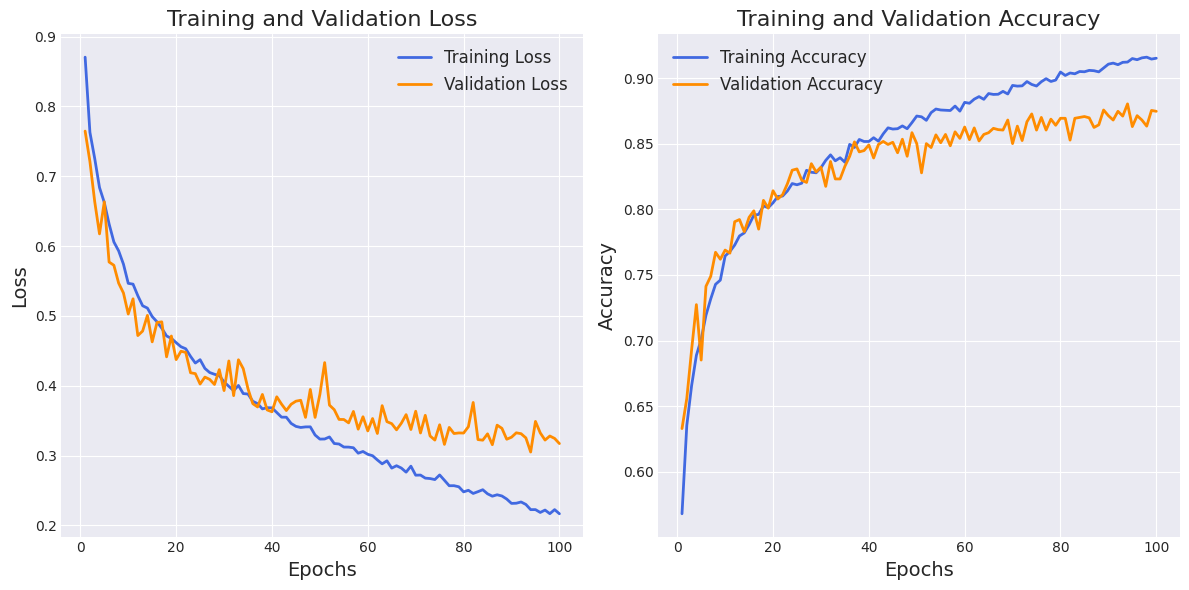

In [122]:
plot_history(history)

Como se puede ver en las gráficas de arriba, el modelo alcanza una precisión aproximada de 0.90 en el conjunto de entrenamiento y 0.8747 en el conjunto de validación. No se observan signos de *overfitting*, ya que la pérdida y el *accuracy* en el conjunto de validación siguen tendencias similares a las del conjunto de entrenamiento. Además, la diferencia entre ambas no es significativa en los últimos epochs, lo que indica que el modelo está generalizando bien y no se ha sobreajustado a los datos de entrenamiento.

In [321]:
def evaluate_model(model, dataloader, class_names):
    """
    Evaluate the model using the given data.
    
    Parameters:
    - model: The model to evaluate.
    - dataloader: The DataLoader object containing the test data.
    - class_names: A list of class names corresponding to the target classes.
    
    Returns:
    - A dictionary containing the evaluation
      metrics, a classification report, and 
      the confusion matrix.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Lists to store the predictions and labels
    all_preds = []
    all_labels = []

    # Disable gradient computation
    with torch.no_grad():
        for batch in dataloader:
            # Get the input data and move it to the device
            X, y = batch
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            y_hat = model(X)
           
            # Get the predicted labels
            preds = y_hat.argmax(dim=1)
            
            # Store the predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Generate a classification report (includes precision, recall, f1-score per class)
    class_report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)
    
    # Convert the classification report to a DataFrame
    report_df = pd.DataFrame(class_report).transpose()

    # Round the values in the DataFrame to 2 decimal places
    report_df = report_df.round(2)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Store metrics, classification report, and confusion matrix in a dictionary
    evaluation_results = {
        'classification_report': report_df,
        'confusion_matrix': conf_matrix
    }

    return evaluation_results

In [143]:
# Define the class names
selected_classes = ['cat', 'dog', 'frog']

# After training the model, evaluate it using the test set
results = evaluate_model(model, testloader, selected_classes)

In [144]:
# Display the classification report
print(results['classification_report'])

              precision  recall  f1-score  support
cat                0.80    0.85      0.83  1000.00
dog                0.88    0.81      0.84  1000.00
frog               0.94    0.95      0.95  1000.00
accuracy           0.87    0.87      0.87     0.87
macro avg          0.87    0.87      0.87  3000.00
weighted avg       0.87    0.87      0.87  3000.00


Como se puede ver en la tabla resumen, se obtienen métricas de evaluación que indican una buena capacidad de generalización del modelo. En particular, se obtiene un *accuracy* de 0.8747. En general, para las métricas de recall, precisión y F1-score, también se obtienen valores altos, por encima de 0.80, lo que indica que el modelo esta mostrando un buen desempeño para la tarea de clasificación requerida.

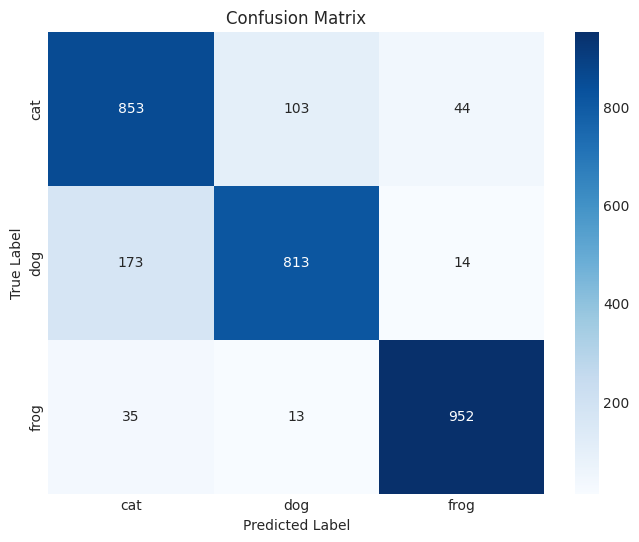

In [145]:
conf_matrix = results['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Igualmente, en la matríz de confusión se puede observar que el modelo tiene una buena capacidad de diferenciar entre las clases de gato, perro y rana, mostrando en su mayoría clasificaciones correctas.

A continuación, se definirá una función que permitirá guardar el modelo entrenado, para poder cargarlo posteriormente si es necesario.

In [162]:
def save_model_with_metrics(model, history, path="", filename_prefix="model", kernel_size=None):
    """
    Save the model with a filename that includes the final validation loss and accuracy.

    Parameters:
    - model: The PyTorch model to be saved.
    - history: A dictionary containing the training history with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'.
    - path: The directory path where the model will be saved (default is the current directory).
    - filename_prefix: A prefix for the filename (default is "model").
    - kernel_size: Optional kernel size to include in the filename.

    Returns:
    - model_filename: The filename used to save the model.
    """
    # Obtaining the final metrics
    final_train_loss = list(history['train_loss'])[-1]
    final_val_loss = list(history['val_loss'])[-1]
    final_train_acc = list(history['train_acc'])[-1]
    final_val_acc = list(history['val_acc'])[-1]

    # Create a filename for the model
    if kernel_size is not None:
        model_filename = f"{filename_prefix}_kernel{kernel_size}_loss{final_val_loss:.2f}_acc{final_val_acc:.2f}.pth"
    else:
        model_filename = f"{filename_prefix}_loss{final_val_loss:.2f}_acc{final_val_acc:.2f}.pth"

    # Combine the path and filename
    full_path = os.path.join(path, model_filename)

    # Save the model to a file
    torch.save(model.state_dict(), full_path)

    print(f'Model saved as {full_path}')
    return full_path

Se guarda el modelo utilizando el accuaracy y la pérdida en el conjunto de validación como identificador del modelo

In [163]:
model_filename = save_model_with_metrics(model, history, path="models", filename_prefix="cifar10_cnn", kernel_size=5)

Model saved as models/cifar10_cnn_kernel5_loss0.32_acc0.87.pth


##  Experimento con tamaño de kernel 7x7

En esta sección, se entrenará el modelo con un tamaño de kernel de 7x7 y se evaluará su comportamiento en términos de la pérdida y el *accuracy*.

In [167]:
model_kernel7 = CNN(kernel_size=7)
history_kernel7 = fit(model_kernel7, {'train': trainloader, 'test': testloader}, epochs=100)

Training Epoch 1/100: 100%|██████████| 938/938 [00:05<00:00, 164.87it/s]


Epoch 1/100 | Train Loss: 0.8868 | Train Acc: 0.5636 | Val Loss: 0.7905 | Val Acc: 0.6273


Training Epoch 2/100: 100%|██████████| 938/938 [00:05<00:00, 185.37it/s]


Epoch 2/100 | Train Loss: 0.7759 | Train Acc: 0.6283 | Val Loss: 0.7090 | Val Acc: 0.6702


Training Epoch 3/100: 100%|██████████| 938/938 [00:05<00:00, 175.49it/s]


Epoch 3/100 | Train Loss: 0.7228 | Train Acc: 0.6652 | Val Loss: 0.6626 | Val Acc: 0.6878


Training Epoch 4/100: 100%|██████████| 938/938 [00:05<00:00, 185.95it/s]


Epoch 4/100 | Train Loss: 0.6980 | Train Acc: 0.6781 | Val Loss: 0.6880 | Val Acc: 0.6828


Training Epoch 5/100: 100%|██████████| 938/938 [00:05<00:00, 181.48it/s]


Epoch 5/100 | Train Loss: 0.6672 | Train Acc: 0.7011 | Val Loss: 0.6043 | Val Acc: 0.7214


Training Epoch 6/100: 100%|██████████| 938/938 [00:05<00:00, 185.25it/s]


Epoch 6/100 | Train Loss: 0.6520 | Train Acc: 0.7106 | Val Loss: 0.6029 | Val Acc: 0.7291


Training Epoch 7/100: 100%|██████████| 938/938 [00:05<00:00, 185.29it/s]


Epoch 7/100 | Train Loss: 0.6281 | Train Acc: 0.7218 | Val Loss: 0.5709 | Val Acc: 0.7467


Training Epoch 8/100: 100%|██████████| 938/938 [00:05<00:00, 185.20it/s]


Epoch 8/100 | Train Loss: 0.6157 | Train Acc: 0.7283 | Val Loss: 0.6247 | Val Acc: 0.7181


Training Epoch 9/100: 100%|██████████| 938/938 [00:05<00:00, 185.34it/s]


Epoch 9/100 | Train Loss: 0.5935 | Train Acc: 0.7425 | Val Loss: 0.6027 | Val Acc: 0.7307


Training Epoch 10/100: 100%|██████████| 938/938 [00:05<00:00, 184.49it/s]


Epoch 10/100 | Train Loss: 0.5813 | Train Acc: 0.7500 | Val Loss: 0.5387 | Val Acc: 0.7703


Training Epoch 11/100: 100%|██████████| 938/938 [00:05<00:00, 184.34it/s]


Epoch 11/100 | Train Loss: 0.5652 | Train Acc: 0.7529 | Val Loss: 0.6038 | Val Acc: 0.7477


Training Epoch 12/100: 100%|██████████| 938/938 [00:05<00:00, 184.73it/s]


Epoch 12/100 | Train Loss: 0.5504 | Train Acc: 0.7599 | Val Loss: 0.5232 | Val Acc: 0.7749


Training Epoch 13/100: 100%|██████████| 938/938 [00:05<00:00, 182.65it/s]


Epoch 13/100 | Train Loss: 0.5444 | Train Acc: 0.7647 | Val Loss: 0.5216 | Val Acc: 0.7723


Training Epoch 14/100: 100%|██████████| 938/938 [00:05<00:00, 183.71it/s]


Epoch 14/100 | Train Loss: 0.5289 | Train Acc: 0.7712 | Val Loss: 0.5174 | Val Acc: 0.7746


Training Epoch 15/100: 100%|██████████| 938/938 [00:05<00:00, 179.14it/s]


Epoch 15/100 | Train Loss: 0.5258 | Train Acc: 0.7779 | Val Loss: 0.5121 | Val Acc: 0.7753


Training Epoch 16/100: 100%|██████████| 938/938 [00:05<00:00, 180.05it/s]


Epoch 16/100 | Train Loss: 0.5107 | Train Acc: 0.7791 | Val Loss: 0.5073 | Val Acc: 0.7753


Training Epoch 17/100: 100%|██████████| 938/938 [00:05<00:00, 182.06it/s]


Epoch 17/100 | Train Loss: 0.5032 | Train Acc: 0.7858 | Val Loss: 0.4829 | Val Acc: 0.7922


Training Epoch 18/100: 100%|██████████| 938/938 [00:05<00:00, 180.49it/s]


Epoch 18/100 | Train Loss: 0.4994 | Train Acc: 0.7891 | Val Loss: 0.4777 | Val Acc: 0.7916


Training Epoch 19/100: 100%|██████████| 938/938 [00:05<00:00, 183.35it/s]


Epoch 19/100 | Train Loss: 0.4916 | Train Acc: 0.7928 | Val Loss: 0.4892 | Val Acc: 0.7836


Training Epoch 20/100: 100%|██████████| 938/938 [00:05<00:00, 176.59it/s]


Epoch 20/100 | Train Loss: 0.4861 | Train Acc: 0.7973 | Val Loss: 0.4884 | Val Acc: 0.7889


Training Epoch 21/100: 100%|██████████| 938/938 [00:05<00:00, 178.50it/s]


Epoch 21/100 | Train Loss: 0.4822 | Train Acc: 0.7954 | Val Loss: 0.4839 | Val Acc: 0.7919


Training Epoch 22/100: 100%|██████████| 938/938 [00:05<00:00, 183.69it/s]


Epoch 22/100 | Train Loss: 0.4711 | Train Acc: 0.8017 | Val Loss: 0.4692 | Val Acc: 0.7929


Training Epoch 23/100: 100%|██████████| 938/938 [00:04<00:00, 189.54it/s]


Epoch 23/100 | Train Loss: 0.4658 | Train Acc: 0.8057 | Val Loss: 0.4861 | Val Acc: 0.7919


Training Epoch 24/100: 100%|██████████| 938/938 [00:04<00:00, 188.45it/s]


Epoch 24/100 | Train Loss: 0.4583 | Train Acc: 0.8044 | Val Loss: 0.4563 | Val Acc: 0.8002


Training Epoch 25/100: 100%|██████████| 938/938 [00:05<00:00, 186.68it/s]


Epoch 25/100 | Train Loss: 0.4532 | Train Acc: 0.8118 | Val Loss: 0.4607 | Val Acc: 0.7942


Training Epoch 26/100: 100%|██████████| 938/938 [00:04<00:00, 188.63it/s]


Epoch 26/100 | Train Loss: 0.4490 | Train Acc: 0.8130 | Val Loss: 0.4903 | Val Acc: 0.7866


Training Epoch 27/100: 100%|██████████| 938/938 [00:05<00:00, 187.02it/s]


Epoch 27/100 | Train Loss: 0.4418 | Train Acc: 0.8183 | Val Loss: 0.5056 | Val Acc: 0.7793


Training Epoch 28/100: 100%|██████████| 938/938 [00:05<00:00, 186.88it/s]


Epoch 28/100 | Train Loss: 0.4377 | Train Acc: 0.8189 | Val Loss: 0.4435 | Val Acc: 0.8068


Training Epoch 29/100: 100%|██████████| 938/938 [00:05<00:00, 186.86it/s]


Epoch 29/100 | Train Loss: 0.4384 | Train Acc: 0.8183 | Val Loss: 0.4712 | Val Acc: 0.7975


Training Epoch 30/100: 100%|██████████| 938/938 [00:04<00:00, 188.82it/s]


Epoch 30/100 | Train Loss: 0.4294 | Train Acc: 0.8200 | Val Loss: 0.4427 | Val Acc: 0.8102


Training Epoch 31/100: 100%|██████████| 938/938 [00:04<00:00, 188.27it/s]


Epoch 31/100 | Train Loss: 0.4239 | Train Acc: 0.8220 | Val Loss: 0.4304 | Val Acc: 0.8145


Training Epoch 32/100: 100%|██████████| 938/938 [00:05<00:00, 187.27it/s]


Epoch 32/100 | Train Loss: 0.4153 | Train Acc: 0.8285 | Val Loss: 0.4411 | Val Acc: 0.8148


Training Epoch 33/100: 100%|██████████| 938/938 [00:05<00:00, 187.51it/s]


Epoch 33/100 | Train Loss: 0.4152 | Train Acc: 0.8297 | Val Loss: 0.5087 | Val Acc: 0.7945


Training Epoch 34/100: 100%|██████████| 938/938 [00:04<00:00, 189.08it/s]


Epoch 34/100 | Train Loss: 0.4127 | Train Acc: 0.8291 | Val Loss: 0.4208 | Val Acc: 0.8278


Training Epoch 35/100: 100%|██████████| 938/938 [00:05<00:00, 164.32it/s]


Epoch 35/100 | Train Loss: 0.4082 | Train Acc: 0.8306 | Val Loss: 0.4171 | Val Acc: 0.8238


Training Epoch 36/100: 100%|██████████| 938/938 [00:05<00:00, 168.27it/s]


Epoch 36/100 | Train Loss: 0.4007 | Train Acc: 0.8344 | Val Loss: 0.4186 | Val Acc: 0.8255


Training Epoch 37/100: 100%|██████████| 938/938 [00:05<00:00, 168.02it/s]


Epoch 37/100 | Train Loss: 0.3978 | Train Acc: 0.8360 | Val Loss: 0.4100 | Val Acc: 0.8248


Training Epoch 38/100: 100%|██████████| 938/938 [00:05<00:00, 165.11it/s]


Epoch 38/100 | Train Loss: 0.3922 | Train Acc: 0.8392 | Val Loss: 0.4094 | Val Acc: 0.8238


Training Epoch 39/100: 100%|██████████| 938/938 [00:05<00:00, 165.09it/s]


Epoch 39/100 | Train Loss: 0.3945 | Train Acc: 0.8389 | Val Loss: 0.4124 | Val Acc: 0.8324


Training Epoch 40/100: 100%|██████████| 938/938 [00:05<00:00, 164.30it/s]


Epoch 40/100 | Train Loss: 0.3839 | Train Acc: 0.8404 | Val Loss: 0.4065 | Val Acc: 0.8245


Training Epoch 41/100: 100%|██████████| 938/938 [00:05<00:00, 161.54it/s]


Epoch 41/100 | Train Loss: 0.3755 | Train Acc: 0.8461 | Val Loss: 0.4168 | Val Acc: 0.8201


Training Epoch 42/100: 100%|██████████| 938/938 [00:05<00:00, 162.51it/s]


Epoch 42/100 | Train Loss: 0.3802 | Train Acc: 0.8477 | Val Loss: 0.4119 | Val Acc: 0.8321


Training Epoch 43/100: 100%|██████████| 938/938 [00:05<00:00, 161.78it/s]


Epoch 43/100 | Train Loss: 0.3764 | Train Acc: 0.8451 | Val Loss: 0.4010 | Val Acc: 0.8338


Training Epoch 44/100: 100%|██████████| 938/938 [00:05<00:00, 163.07it/s]


Epoch 44/100 | Train Loss: 0.3654 | Train Acc: 0.8501 | Val Loss: 0.3971 | Val Acc: 0.8364


Training Epoch 45/100: 100%|██████████| 938/938 [00:05<00:00, 166.80it/s]


Epoch 45/100 | Train Loss: 0.3657 | Train Acc: 0.8519 | Val Loss: 0.4380 | Val Acc: 0.8185


Training Epoch 46/100: 100%|██████████| 938/938 [00:05<00:00, 162.95it/s]


Epoch 46/100 | Train Loss: 0.3617 | Train Acc: 0.8530 | Val Loss: 0.3922 | Val Acc: 0.8398


Training Epoch 47/100: 100%|██████████| 938/938 [00:05<00:00, 165.60it/s]


Epoch 47/100 | Train Loss: 0.3592 | Train Acc: 0.8567 | Val Loss: 0.4002 | Val Acc: 0.8291


Training Epoch 48/100: 100%|██████████| 938/938 [00:05<00:00, 167.10it/s]


Epoch 48/100 | Train Loss: 0.3516 | Train Acc: 0.8579 | Val Loss: 0.3932 | Val Acc: 0.8441


Training Epoch 49/100: 100%|██████████| 938/938 [00:05<00:00, 185.71it/s]


Epoch 49/100 | Train Loss: 0.3474 | Train Acc: 0.8606 | Val Loss: 0.3865 | Val Acc: 0.8378


Training Epoch 50/100: 100%|██████████| 938/938 [00:04<00:00, 188.80it/s]


Epoch 50/100 | Train Loss: 0.3501 | Train Acc: 0.8587 | Val Loss: 0.3876 | Val Acc: 0.8384


Training Epoch 51/100: 100%|██████████| 938/938 [00:04<00:00, 188.01it/s]


Epoch 51/100 | Train Loss: 0.3447 | Train Acc: 0.8615 | Val Loss: 0.3847 | Val Acc: 0.8384


Training Epoch 52/100: 100%|██████████| 938/938 [00:04<00:00, 187.66it/s]


Epoch 52/100 | Train Loss: 0.3394 | Train Acc: 0.8603 | Val Loss: 0.3900 | Val Acc: 0.8364


Training Epoch 53/100: 100%|██████████| 938/938 [00:04<00:00, 187.62it/s]


Epoch 53/100 | Train Loss: 0.3436 | Train Acc: 0.8633 | Val Loss: 0.4028 | Val Acc: 0.8275


Training Epoch 54/100: 100%|██████████| 938/938 [00:05<00:00, 175.32it/s]


Epoch 54/100 | Train Loss: 0.3306 | Train Acc: 0.8671 | Val Loss: 0.3900 | Val Acc: 0.8404


Training Epoch 55/100: 100%|██████████| 938/938 [00:05<00:00, 176.19it/s]


Epoch 55/100 | Train Loss: 0.3250 | Train Acc: 0.8688 | Val Loss: 0.4008 | Val Acc: 0.8314


Training Epoch 56/100: 100%|██████████| 938/938 [00:05<00:00, 166.84it/s]


Epoch 56/100 | Train Loss: 0.3285 | Train Acc: 0.8689 | Val Loss: 0.3905 | Val Acc: 0.8388


Training Epoch 57/100: 100%|██████████| 938/938 [00:05<00:00, 165.73it/s]


Epoch 57/100 | Train Loss: 0.3275 | Train Acc: 0.8705 | Val Loss: 0.3809 | Val Acc: 0.8401


Training Epoch 58/100: 100%|██████████| 938/938 [00:05<00:00, 167.79it/s]


Epoch 58/100 | Train Loss: 0.3152 | Train Acc: 0.8755 | Val Loss: 0.3867 | Val Acc: 0.8411


Training Epoch 59/100: 100%|██████████| 938/938 [00:05<00:00, 167.07it/s]


Epoch 59/100 | Train Loss: 0.3163 | Train Acc: 0.8735 | Val Loss: 0.3986 | Val Acc: 0.8285


Training Epoch 60/100: 100%|██████████| 938/938 [00:05<00:00, 176.26it/s]


Epoch 60/100 | Train Loss: 0.3090 | Train Acc: 0.8759 | Val Loss: 0.3970 | Val Acc: 0.8371


Training Epoch 61/100: 100%|██████████| 938/938 [00:05<00:00, 166.30it/s]


Epoch 61/100 | Train Loss: 0.3144 | Train Acc: 0.8745 | Val Loss: 0.3508 | Val Acc: 0.8497


Training Epoch 62/100: 100%|██████████| 938/938 [00:05<00:00, 167.24it/s]


Epoch 62/100 | Train Loss: 0.3099 | Train Acc: 0.8757 | Val Loss: 0.4061 | Val Acc: 0.8308


Training Epoch 63/100: 100%|██████████| 938/938 [00:05<00:00, 166.23it/s]


Epoch 63/100 | Train Loss: 0.3055 | Train Acc: 0.8810 | Val Loss: 0.3647 | Val Acc: 0.8438


Training Epoch 64/100: 100%|██████████| 938/938 [00:05<00:00, 186.21it/s]


Epoch 64/100 | Train Loss: 0.2961 | Train Acc: 0.8843 | Val Loss: 0.4798 | Val Acc: 0.8195


Training Epoch 65/100: 100%|██████████| 938/938 [00:05<00:00, 183.26it/s]


Epoch 65/100 | Train Loss: 0.2986 | Train Acc: 0.8831 | Val Loss: 0.3638 | Val Acc: 0.8414


Training Epoch 66/100: 100%|██████████| 938/938 [00:05<00:00, 186.65it/s]


Epoch 66/100 | Train Loss: 0.2977 | Train Acc: 0.8825 | Val Loss: 0.3745 | Val Acc: 0.8471


Training Epoch 67/100: 100%|██████████| 938/938 [00:04<00:00, 188.30it/s]


Epoch 67/100 | Train Loss: 0.2929 | Train Acc: 0.8847 | Val Loss: 0.4018 | Val Acc: 0.8368


Training Epoch 68/100: 100%|██████████| 938/938 [00:05<00:00, 182.53it/s]


Epoch 68/100 | Train Loss: 0.2886 | Train Acc: 0.8853 | Val Loss: 0.4022 | Val Acc: 0.8341


Training Epoch 69/100: 100%|██████████| 938/938 [00:05<00:00, 187.38it/s]


Epoch 69/100 | Train Loss: 0.2848 | Train Acc: 0.8878 | Val Loss: 0.3694 | Val Acc: 0.8507


Training Epoch 70/100: 100%|██████████| 938/938 [00:05<00:00, 186.21it/s]


Epoch 70/100 | Train Loss: 0.2877 | Train Acc: 0.8874 | Val Loss: 0.3675 | Val Acc: 0.8457


Training Epoch 71/100: 100%|██████████| 938/938 [00:04<00:00, 189.38it/s]


Epoch 71/100 | Train Loss: 0.2865 | Train Acc: 0.8849 | Val Loss: 0.3602 | Val Acc: 0.8484


Training Epoch 72/100: 100%|██████████| 938/938 [00:04<00:00, 188.46it/s]


Epoch 72/100 | Train Loss: 0.2795 | Train Acc: 0.8911 | Val Loss: 0.3767 | Val Acc: 0.8491


Training Epoch 73/100: 100%|██████████| 938/938 [00:04<00:00, 187.88it/s]


Epoch 73/100 | Train Loss: 0.2786 | Train Acc: 0.8923 | Val Loss: 0.3965 | Val Acc: 0.8378


Training Epoch 74/100: 100%|██████████| 938/938 [00:05<00:00, 187.32it/s]


Epoch 74/100 | Train Loss: 0.2780 | Train Acc: 0.8929 | Val Loss: 0.3592 | Val Acc: 0.8564


Training Epoch 75/100: 100%|██████████| 938/938 [00:04<00:00, 187.84it/s]


Epoch 75/100 | Train Loss: 0.2752 | Train Acc: 0.8940 | Val Loss: 0.4144 | Val Acc: 0.8368


Training Epoch 76/100: 100%|██████████| 938/938 [00:04<00:00, 189.73it/s]


Epoch 76/100 | Train Loss: 0.2643 | Train Acc: 0.8974 | Val Loss: 0.4248 | Val Acc: 0.8368


Training Epoch 77/100: 100%|██████████| 938/938 [00:05<00:00, 187.45it/s]


Epoch 77/100 | Train Loss: 0.2671 | Train Acc: 0.8952 | Val Loss: 0.3830 | Val Acc: 0.8431


Training Epoch 78/100: 100%|██████████| 938/938 [00:05<00:00, 186.53it/s]


Epoch 78/100 | Train Loss: 0.2679 | Train Acc: 0.8947 | Val Loss: 0.3708 | Val Acc: 0.8487


Training Epoch 79/100: 100%|██████████| 938/938 [00:04<00:00, 188.64it/s]


Epoch 79/100 | Train Loss: 0.2591 | Train Acc: 0.8991 | Val Loss: 0.4191 | Val Acc: 0.8331


Training Epoch 80/100: 100%|██████████| 938/938 [00:05<00:00, 186.05it/s]


Epoch 80/100 | Train Loss: 0.2542 | Train Acc: 0.9031 | Val Loss: 0.3715 | Val Acc: 0.8537


Training Epoch 81/100: 100%|██████████| 938/938 [00:05<00:00, 187.03it/s]


Epoch 81/100 | Train Loss: 0.2582 | Train Acc: 0.8991 | Val Loss: 0.3689 | Val Acc: 0.8527


Training Epoch 82/100: 100%|██████████| 938/938 [00:05<00:00, 187.47it/s]


Epoch 82/100 | Train Loss: 0.2543 | Train Acc: 0.9023 | Val Loss: 0.3897 | Val Acc: 0.8348


Training Epoch 83/100: 100%|██████████| 938/938 [00:05<00:00, 186.59it/s]


Epoch 83/100 | Train Loss: 0.2527 | Train Acc: 0.9023 | Val Loss: 0.4230 | Val Acc: 0.8338


Training Epoch 84/100: 100%|██████████| 938/938 [00:04<00:00, 188.73it/s]


Epoch 84/100 | Train Loss: 0.2494 | Train Acc: 0.9042 | Val Loss: 0.3737 | Val Acc: 0.8597


Training Epoch 85/100: 100%|██████████| 938/938 [00:05<00:00, 187.06it/s]


Epoch 85/100 | Train Loss: 0.2506 | Train Acc: 0.9017 | Val Loss: 0.3792 | Val Acc: 0.8504


Training Epoch 86/100: 100%|██████████| 938/938 [00:04<00:00, 187.86it/s]


Epoch 86/100 | Train Loss: 0.2457 | Train Acc: 0.9025 | Val Loss: 0.3625 | Val Acc: 0.8514


Training Epoch 87/100: 100%|██████████| 938/938 [00:04<00:00, 188.79it/s]


Epoch 87/100 | Train Loss: 0.2414 | Train Acc: 0.9080 | Val Loss: 0.3531 | Val Acc: 0.8577


Training Epoch 88/100: 100%|██████████| 938/938 [00:04<00:00, 188.77it/s]


Epoch 88/100 | Train Loss: 0.2444 | Train Acc: 0.9046 | Val Loss: 0.3801 | Val Acc: 0.8511


Training Epoch 89/100: 100%|██████████| 938/938 [00:05<00:00, 187.37it/s]


Epoch 89/100 | Train Loss: 0.2400 | Train Acc: 0.9091 | Val Loss: 0.3587 | Val Acc: 0.8524


Training Epoch 90/100: 100%|██████████| 938/938 [00:04<00:00, 188.53it/s]


Epoch 90/100 | Train Loss: 0.2390 | Train Acc: 0.9084 | Val Loss: 0.3497 | Val Acc: 0.8574


Training Epoch 91/100: 100%|██████████| 938/938 [00:05<00:00, 185.93it/s]


Epoch 91/100 | Train Loss: 0.2343 | Train Acc: 0.9116 | Val Loss: 0.3590 | Val Acc: 0.8604


Training Epoch 92/100: 100%|██████████| 938/938 [00:05<00:00, 177.00it/s]


Epoch 92/100 | Train Loss: 0.2345 | Train Acc: 0.9094 | Val Loss: 0.3585 | Val Acc: 0.8624


Training Epoch 93/100: 100%|██████████| 938/938 [00:05<00:00, 186.59it/s]


Epoch 93/100 | Train Loss: 0.2362 | Train Acc: 0.9088 | Val Loss: 0.3570 | Val Acc: 0.8564


Training Epoch 94/100: 100%|██████████| 938/938 [00:04<00:00, 187.79it/s]


Epoch 94/100 | Train Loss: 0.2316 | Train Acc: 0.9099 | Val Loss: 0.3618 | Val Acc: 0.8570


Training Epoch 95/100: 100%|██████████| 938/938 [00:05<00:00, 183.13it/s]


Epoch 95/100 | Train Loss: 0.2306 | Train Acc: 0.9111 | Val Loss: 0.3432 | Val Acc: 0.8604


Training Epoch 96/100: 100%|██████████| 938/938 [00:05<00:00, 167.89it/s]


Epoch 96/100 | Train Loss: 0.2210 | Train Acc: 0.9178 | Val Loss: 0.3848 | Val Acc: 0.8494


Training Epoch 97/100: 100%|██████████| 938/938 [00:05<00:00, 172.43it/s]


Epoch 97/100 | Train Loss: 0.2209 | Train Acc: 0.9166 | Val Loss: 0.4295 | Val Acc: 0.8388


Training Epoch 98/100: 100%|██████████| 938/938 [00:05<00:00, 166.09it/s]


Epoch 98/100 | Train Loss: 0.2243 | Train Acc: 0.9166 | Val Loss: 0.3692 | Val Acc: 0.8554


Training Epoch 99/100: 100%|██████████| 938/938 [00:05<00:00, 166.44it/s]


Epoch 99/100 | Train Loss: 0.2237 | Train Acc: 0.9144 | Val Loss: 0.3531 | Val Acc: 0.8597


Training Epoch 100/100: 100%|██████████| 938/938 [00:05<00:00, 167.19it/s]
                                                              

Epoch 100/100 | Train Loss: 0.2167 | Train Acc: 0.9184 | Val Loss: 0.3677 | Val Acc: 0.8570


/tmp/ipykernel_2685/1010231979.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


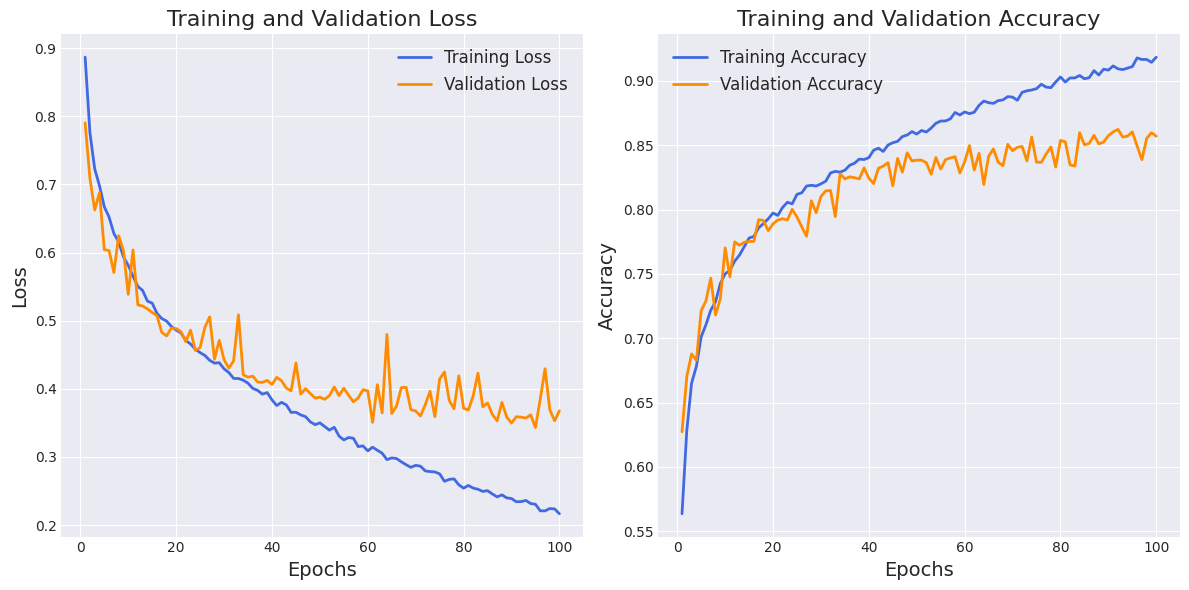

In [168]:
plot_history(history_kernel7)

Se puede ver en las imágenes de arriba que el modelo entrenado con el `kernel_size=7` presenta un comportamiento similar al anterior experimento (con `kernel_size=5`). Sin embargo, en este caso, el modelo no logra alcanzar el mismo accuracy en el conjunto de validación, obteniendo un valor menor de 0.8570, a pesar de haber alcanzado un accuracy cercano a 0.90 en el conjunto de entrenamiento. Como se ha realizado el experimento en igualdad de condiciones al caso anterior, solo variando el tamaño del kernel, se puede analizar que incrementar el tamaño del kernel ha afectado negativamente la capacidad de generalización del modelo.

In [169]:
results = evaluate_model(model_kernel7, testloader, selected_classes)

In [170]:
print(results['classification_report'])

              precision  recall  f1-score  support
cat                0.75    0.90      0.82  1000.00
dog                0.90    0.78      0.84  1000.00
frog               0.96    0.90      0.93  1000.00
accuracy           0.86    0.86      0.86     0.86
macro avg          0.87    0.86      0.86  3000.00
weighted avg       0.87    0.86      0.86  3000.00


Se puede ver el impacto antes mencionado en las demás métricas de evaluación también, donde se obtienen valores ligeramente menores en comparación al experimento anterior. En particular, el recall y la precisión para la clase de perro muestran dicha disminución. En general, el modelo sigue mostrando un buen desempeño, pero se puede observar que el incremento del tamaño del kernel ha afectado negativamente la capacidad de discriminación entre clases del modelo.

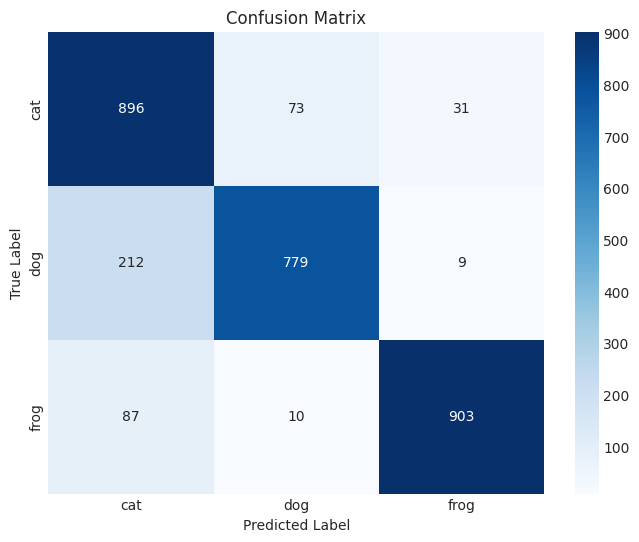

In [171]:
conf_matrix = results['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Lo mismo se puede observar en la matriz de confusión, donde se puede ver que el modelo ha tenido más dificultades para diferenciar entre las clases de perro y gato, llegando a clasificar más imagenes de perro como gato que en el experimento anterior.

In [172]:
model_filename = save_model_with_metrics(model_kernel7, history_kernel7, path="models", filename_prefix="cifar10_cnn", kernel_size=7)

Model saved as models/cifar10_cnn_kernel7_loss0.37_acc0.86.pth


##  Experimento con tamaño de kernel 9x9

En esta sección, se entrenará el modelo con un tamaño de kernel de 9x9 y se evaluará su comportamiento en términos de la pérdida y el *accuracy*.

In [173]:
model_kernel9 = CNN(kernel_size=9)
history_kernel9 = fit(model_kernel9, {'train': trainloader, 'test': testloader}, epochs=100)

Training Epoch 1/100: 100%|██████████| 938/938 [00:06<00:00, 136.29it/s]


Epoch 1/100 | Train Loss: 0.8852 | Train Acc: 0.5602 | Val Loss: 0.7756 | Val Acc: 0.6197


Training Epoch 2/100: 100%|██████████| 938/938 [00:06<00:00, 142.71it/s]


Epoch 2/100 | Train Loss: 0.7766 | Train Acc: 0.6340 | Val Loss: 0.7069 | Val Acc: 0.6702


Training Epoch 3/100: 100%|██████████| 938/938 [00:06<00:00, 144.42it/s]


Epoch 3/100 | Train Loss: 0.7415 | Train Acc: 0.6597 | Val Loss: 0.6772 | Val Acc: 0.6852


Training Epoch 4/100: 100%|██████████| 938/938 [00:06<00:00, 142.71it/s]


Epoch 4/100 | Train Loss: 0.7133 | Train Acc: 0.6713 | Val Loss: 0.6653 | Val Acc: 0.7015


Training Epoch 5/100: 100%|██████████| 938/938 [00:06<00:00, 146.53it/s]


Epoch 5/100 | Train Loss: 0.6920 | Train Acc: 0.6814 | Val Loss: 0.6996 | Val Acc: 0.6842


Training Epoch 6/100: 100%|██████████| 938/938 [00:06<00:00, 146.43it/s]


Epoch 6/100 | Train Loss: 0.6752 | Train Acc: 0.6921 | Val Loss: 0.6716 | Val Acc: 0.7051


Training Epoch 7/100: 100%|██████████| 938/938 [00:06<00:00, 146.89it/s]


Epoch 7/100 | Train Loss: 0.6605 | Train Acc: 0.7010 | Val Loss: 0.5991 | Val Acc: 0.7311


Training Epoch 8/100: 100%|██████████| 938/938 [00:06<00:00, 146.58it/s]


Epoch 8/100 | Train Loss: 0.6420 | Train Acc: 0.7127 | Val Loss: 0.6079 | Val Acc: 0.7287


Training Epoch 9/100: 100%|██████████| 938/938 [00:06<00:00, 147.21it/s]


Epoch 9/100 | Train Loss: 0.6244 | Train Acc: 0.7242 | Val Loss: 0.5904 | Val Acc: 0.7311


Training Epoch 10/100: 100%|██████████| 938/938 [00:06<00:00, 146.64it/s]


Epoch 10/100 | Train Loss: 0.6089 | Train Acc: 0.7348 | Val Loss: 0.5752 | Val Acc: 0.7443


Training Epoch 11/100: 100%|██████████| 938/938 [00:06<00:00, 145.84it/s]


Epoch 11/100 | Train Loss: 0.5993 | Train Acc: 0.7331 | Val Loss: 0.5613 | Val Acc: 0.7557


Training Epoch 12/100: 100%|██████████| 938/938 [00:06<00:00, 145.88it/s]


Epoch 12/100 | Train Loss: 0.5833 | Train Acc: 0.7441 | Val Loss: 0.5424 | Val Acc: 0.7547


Training Epoch 13/100: 100%|██████████| 938/938 [00:06<00:00, 144.19it/s]


Epoch 13/100 | Train Loss: 0.5730 | Train Acc: 0.7472 | Val Loss: 0.5531 | Val Acc: 0.7510


Training Epoch 14/100: 100%|██████████| 938/938 [00:06<00:00, 144.63it/s]


Epoch 14/100 | Train Loss: 0.5639 | Train Acc: 0.7533 | Val Loss: 0.5287 | Val Acc: 0.7640


Training Epoch 15/100: 100%|██████████| 938/938 [00:06<00:00, 146.30it/s]


Epoch 15/100 | Train Loss: 0.5500 | Train Acc: 0.7611 | Val Loss: 0.5364 | Val Acc: 0.7656


Training Epoch 16/100: 100%|██████████| 938/938 [00:06<00:00, 144.40it/s]


Epoch 16/100 | Train Loss: 0.5406 | Train Acc: 0.7689 | Val Loss: 0.5382 | Val Acc: 0.7703


Training Epoch 17/100: 100%|██████████| 938/938 [00:06<00:00, 145.81it/s]


Epoch 17/100 | Train Loss: 0.5268 | Train Acc: 0.7743 | Val Loss: 0.5121 | Val Acc: 0.7736


Training Epoch 18/100: 100%|██████████| 938/938 [00:06<00:00, 142.59it/s]


Epoch 18/100 | Train Loss: 0.5248 | Train Acc: 0.7722 | Val Loss: 0.5875 | Val Acc: 0.7354


Training Epoch 19/100: 100%|██████████| 938/938 [00:06<00:00, 147.70it/s]


Epoch 19/100 | Train Loss: 0.5167 | Train Acc: 0.7780 | Val Loss: 0.5332 | Val Acc: 0.7686


Training Epoch 20/100: 100%|██████████| 938/938 [00:06<00:00, 147.88it/s]


Epoch 20/100 | Train Loss: 0.5098 | Train Acc: 0.7832 | Val Loss: 0.4868 | Val Acc: 0.7889


Training Epoch 21/100: 100%|██████████| 938/938 [00:06<00:00, 139.48it/s]


Epoch 21/100 | Train Loss: 0.5007 | Train Acc: 0.7880 | Val Loss: 0.5390 | Val Acc: 0.7623


Training Epoch 22/100: 100%|██████████| 938/938 [00:06<00:00, 135.97it/s]


Epoch 22/100 | Train Loss: 0.4946 | Train Acc: 0.7916 | Val Loss: 0.5073 | Val Acc: 0.7816


Training Epoch 23/100: 100%|██████████| 938/938 [00:06<00:00, 135.48it/s]


Epoch 23/100 | Train Loss: 0.4895 | Train Acc: 0.7931 | Val Loss: 0.4791 | Val Acc: 0.7962


Training Epoch 24/100: 100%|██████████| 938/938 [00:06<00:00, 136.75it/s]


Epoch 24/100 | Train Loss: 0.4805 | Train Acc: 0.7997 | Val Loss: 0.4700 | Val Acc: 0.8035


Training Epoch 25/100: 100%|██████████| 938/938 [00:07<00:00, 133.07it/s]


Epoch 25/100 | Train Loss: 0.4732 | Train Acc: 0.7993 | Val Loss: 0.4827 | Val Acc: 0.8022


Training Epoch 26/100: 100%|██████████| 938/938 [00:06<00:00, 137.18it/s]


Epoch 26/100 | Train Loss: 0.4659 | Train Acc: 0.8046 | Val Loss: 0.4879 | Val Acc: 0.7866


Training Epoch 27/100: 100%|██████████| 938/938 [00:07<00:00, 130.29it/s]


Epoch 27/100 | Train Loss: 0.4635 | Train Acc: 0.8068 | Val Loss: 0.4485 | Val Acc: 0.8039


Training Epoch 28/100: 100%|██████████| 938/938 [00:07<00:00, 127.75it/s]


Epoch 28/100 | Train Loss: 0.4585 | Train Acc: 0.8065 | Val Loss: 0.4554 | Val Acc: 0.8022


Training Epoch 29/100: 100%|██████████| 938/938 [00:06<00:00, 135.71it/s]


Epoch 29/100 | Train Loss: 0.4564 | Train Acc: 0.8074 | Val Loss: 0.4886 | Val Acc: 0.7929


Training Epoch 30/100: 100%|██████████| 938/938 [00:06<00:00, 135.38it/s]


Epoch 30/100 | Train Loss: 0.4457 | Train Acc: 0.8136 | Val Loss: 0.5690 | Val Acc: 0.7586


Training Epoch 31/100: 100%|██████████| 938/938 [00:06<00:00, 135.90it/s]


Epoch 31/100 | Train Loss: 0.4428 | Train Acc: 0.8167 | Val Loss: 0.5345 | Val Acc: 0.7812


Training Epoch 32/100: 100%|██████████| 938/938 [00:06<00:00, 137.12it/s]


Epoch 32/100 | Train Loss: 0.4331 | Train Acc: 0.8195 | Val Loss: 0.4553 | Val Acc: 0.8098


Training Epoch 33/100: 100%|██████████| 938/938 [00:06<00:00, 148.82it/s]


Epoch 33/100 | Train Loss: 0.4334 | Train Acc: 0.8193 | Val Loss: 0.4596 | Val Acc: 0.8078


Training Epoch 34/100: 100%|██████████| 938/938 [00:06<00:00, 148.86it/s]


Epoch 34/100 | Train Loss: 0.4288 | Train Acc: 0.8199 | Val Loss: 0.4695 | Val Acc: 0.7985


Training Epoch 35/100: 100%|██████████| 938/938 [00:06<00:00, 149.00it/s]


Epoch 35/100 | Train Loss: 0.4174 | Train Acc: 0.8276 | Val Loss: 0.4896 | Val Acc: 0.7985


Training Epoch 36/100: 100%|██████████| 938/938 [00:06<00:00, 148.22it/s]


Epoch 36/100 | Train Loss: 0.4085 | Train Acc: 0.8329 | Val Loss: 0.4845 | Val Acc: 0.8022


Training Epoch 37/100: 100%|██████████| 938/938 [00:06<00:00, 140.67it/s]


Epoch 37/100 | Train Loss: 0.4122 | Train Acc: 0.8324 | Val Loss: 0.4459 | Val Acc: 0.8138


Training Epoch 38/100: 100%|██████████| 938/938 [00:06<00:00, 138.79it/s]


Epoch 38/100 | Train Loss: 0.4094 | Train Acc: 0.8346 | Val Loss: 0.4407 | Val Acc: 0.8062


Training Epoch 39/100: 100%|██████████| 938/938 [00:06<00:00, 140.18it/s]


Epoch 39/100 | Train Loss: 0.4073 | Train Acc: 0.8319 | Val Loss: 0.4389 | Val Acc: 0.8152


Training Epoch 40/100: 100%|██████████| 938/938 [00:06<00:00, 137.62it/s]


Epoch 40/100 | Train Loss: 0.4003 | Train Acc: 0.8362 | Val Loss: 0.4683 | Val Acc: 0.8015


Training Epoch 41/100: 100%|██████████| 938/938 [00:06<00:00, 136.18it/s]


Epoch 41/100 | Train Loss: 0.3931 | Train Acc: 0.8380 | Val Loss: 0.4979 | Val Acc: 0.7979


Training Epoch 42/100: 100%|██████████| 938/938 [00:06<00:00, 136.92it/s]


Epoch 42/100 | Train Loss: 0.3962 | Train Acc: 0.8370 | Val Loss: 0.4446 | Val Acc: 0.8152


Training Epoch 43/100: 100%|██████████| 938/938 [00:06<00:00, 137.76it/s]


Epoch 43/100 | Train Loss: 0.3830 | Train Acc: 0.8430 | Val Loss: 0.4103 | Val Acc: 0.8328


Training Epoch 44/100: 100%|██████████| 938/938 [00:06<00:00, 137.92it/s]


Epoch 44/100 | Train Loss: 0.3810 | Train Acc: 0.8473 | Val Loss: 0.4313 | Val Acc: 0.8142


Training Epoch 45/100: 100%|██████████| 938/938 [00:06<00:00, 146.63it/s]


Epoch 45/100 | Train Loss: 0.3773 | Train Acc: 0.8481 | Val Loss: 0.4195 | Val Acc: 0.8271


Training Epoch 46/100: 100%|██████████| 938/938 [00:06<00:00, 147.29it/s]


Epoch 46/100 | Train Loss: 0.3688 | Train Acc: 0.8518 | Val Loss: 0.4682 | Val Acc: 0.8108


Training Epoch 47/100: 100%|██████████| 938/938 [00:06<00:00, 146.46it/s]


Epoch 47/100 | Train Loss: 0.3729 | Train Acc: 0.8487 | Val Loss: 0.4383 | Val Acc: 0.8158


Training Epoch 48/100: 100%|██████████| 938/938 [00:06<00:00, 145.02it/s]


Epoch 48/100 | Train Loss: 0.3711 | Train Acc: 0.8507 | Val Loss: 0.4547 | Val Acc: 0.8102


Training Epoch 49/100: 100%|██████████| 938/938 [00:06<00:00, 148.58it/s]


Epoch 49/100 | Train Loss: 0.3674 | Train Acc: 0.8525 | Val Loss: 0.4265 | Val Acc: 0.8211


Training Epoch 50/100: 100%|██████████| 938/938 [00:06<00:00, 149.08it/s]


Epoch 50/100 | Train Loss: 0.3578 | Train Acc: 0.8525 | Val Loss: 0.4489 | Val Acc: 0.8162


Training Epoch 51/100: 100%|██████████| 938/938 [00:06<00:00, 148.33it/s]


Epoch 51/100 | Train Loss: 0.3561 | Train Acc: 0.8606 | Val Loss: 0.4267 | Val Acc: 0.8172


Training Epoch 52/100: 100%|██████████| 938/938 [00:06<00:00, 148.79it/s]


Epoch 52/100 | Train Loss: 0.3496 | Train Acc: 0.8575 | Val Loss: 0.4265 | Val Acc: 0.8205


Training Epoch 53/100: 100%|██████████| 938/938 [00:06<00:00, 148.86it/s]


Epoch 53/100 | Train Loss: 0.3417 | Train Acc: 0.8624 | Val Loss: 0.4510 | Val Acc: 0.8172


Training Epoch 54/100: 100%|██████████| 938/938 [00:06<00:00, 148.72it/s]


Epoch 54/100 | Train Loss: 0.3482 | Train Acc: 0.8611 | Val Loss: 0.4236 | Val Acc: 0.8265


Training Epoch 55/100: 100%|██████████| 938/938 [00:06<00:00, 149.31it/s]


Epoch 55/100 | Train Loss: 0.3426 | Train Acc: 0.8627 | Val Loss: 0.4491 | Val Acc: 0.8102


Training Epoch 56/100: 100%|██████████| 938/938 [00:06<00:00, 149.58it/s]


Epoch 56/100 | Train Loss: 0.3361 | Train Acc: 0.8647 | Val Loss: 0.4388 | Val Acc: 0.8198


Training Epoch 57/100: 100%|██████████| 938/938 [00:06<00:00, 149.63it/s]


Epoch 57/100 | Train Loss: 0.3294 | Train Acc: 0.8687 | Val Loss: 0.4675 | Val Acc: 0.8118


Training Epoch 58/100: 100%|██████████| 938/938 [00:06<00:00, 148.60it/s]


Epoch 58/100 | Train Loss: 0.3328 | Train Acc: 0.8669 | Val Loss: 0.4073 | Val Acc: 0.8348


Training Epoch 59/100: 100%|██████████| 938/938 [00:06<00:00, 148.88it/s]


Epoch 59/100 | Train Loss: 0.3240 | Train Acc: 0.8719 | Val Loss: 0.4248 | Val Acc: 0.8195


Training Epoch 60/100: 100%|██████████| 938/938 [00:06<00:00, 139.75it/s]


Epoch 60/100 | Train Loss: 0.3240 | Train Acc: 0.8730 | Val Loss: 0.4376 | Val Acc: 0.8138


Training Epoch 61/100: 100%|██████████| 938/938 [00:06<00:00, 139.99it/s]


Epoch 61/100 | Train Loss: 0.3200 | Train Acc: 0.8714 | Val Loss: 0.4229 | Val Acc: 0.8314


Training Epoch 62/100: 100%|██████████| 938/938 [00:06<00:00, 134.58it/s]


Epoch 62/100 | Train Loss: 0.3193 | Train Acc: 0.8772 | Val Loss: 0.4110 | Val Acc: 0.8311


Training Epoch 63/100: 100%|██████████| 938/938 [00:06<00:00, 135.54it/s]


Epoch 63/100 | Train Loss: 0.3115 | Train Acc: 0.8754 | Val Loss: 0.4342 | Val Acc: 0.8221


Training Epoch 64/100: 100%|██████████| 938/938 [00:06<00:00, 137.07it/s]


Epoch 64/100 | Train Loss: 0.3121 | Train Acc: 0.8786 | Val Loss: 0.4006 | Val Acc: 0.8311


Training Epoch 65/100: 100%|██████████| 938/938 [00:06<00:00, 138.46it/s]


Epoch 65/100 | Train Loss: 0.3031 | Train Acc: 0.8811 | Val Loss: 0.4197 | Val Acc: 0.8344


Training Epoch 66/100: 100%|██████████| 938/938 [00:06<00:00, 134.67it/s]


Epoch 66/100 | Train Loss: 0.3049 | Train Acc: 0.8837 | Val Loss: 0.4102 | Val Acc: 0.8334


Training Epoch 67/100: 100%|██████████| 938/938 [00:06<00:00, 137.59it/s]


Epoch 67/100 | Train Loss: 0.2976 | Train Acc: 0.8839 | Val Loss: 0.3991 | Val Acc: 0.8368


Training Epoch 68/100: 100%|██████████| 938/938 [00:06<00:00, 139.56it/s]


Epoch 68/100 | Train Loss: 0.3009 | Train Acc: 0.8861 | Val Loss: 0.4012 | Val Acc: 0.8371


Training Epoch 69/100: 100%|██████████| 938/938 [00:06<00:00, 136.71it/s]


Epoch 69/100 | Train Loss: 0.2863 | Train Acc: 0.8903 | Val Loss: 0.4534 | Val Acc: 0.8245


Training Epoch 70/100: 100%|██████████| 938/938 [00:07<00:00, 130.95it/s]


Epoch 70/100 | Train Loss: 0.2909 | Train Acc: 0.8844 | Val Loss: 0.3847 | Val Acc: 0.8497


Training Epoch 71/100: 100%|██████████| 938/938 [00:07<00:00, 127.93it/s]


Epoch 71/100 | Train Loss: 0.2903 | Train Acc: 0.8882 | Val Loss: 0.3894 | Val Acc: 0.8391


Training Epoch 72/100: 100%|██████████| 938/938 [00:07<00:00, 130.17it/s]


Epoch 72/100 | Train Loss: 0.2871 | Train Acc: 0.8877 | Val Loss: 0.5746 | Val Acc: 0.7806


Training Epoch 73/100: 100%|██████████| 938/938 [00:07<00:00, 131.14it/s]


Epoch 73/100 | Train Loss: 0.2863 | Train Acc: 0.8879 | Val Loss: 0.4254 | Val Acc: 0.8271


Training Epoch 74/100: 100%|██████████| 938/938 [00:07<00:00, 127.14it/s]


Epoch 74/100 | Train Loss: 0.2773 | Train Acc: 0.8919 | Val Loss: 0.4492 | Val Acc: 0.8255


Training Epoch 75/100: 100%|██████████| 938/938 [00:07<00:00, 126.26it/s]


Epoch 75/100 | Train Loss: 0.2747 | Train Acc: 0.8902 | Val Loss: 0.4634 | Val Acc: 0.8182


Training Epoch 76/100: 100%|██████████| 938/938 [00:07<00:00, 128.93it/s]


Epoch 76/100 | Train Loss: 0.2822 | Train Acc: 0.8906 | Val Loss: 0.4150 | Val Acc: 0.8321


Training Epoch 77/100: 100%|██████████| 938/938 [00:07<00:00, 127.00it/s]


Epoch 77/100 | Train Loss: 0.2734 | Train Acc: 0.8933 | Val Loss: 0.3705 | Val Acc: 0.8467


Training Epoch 78/100: 100%|██████████| 938/938 [00:07<00:00, 133.71it/s]


Epoch 78/100 | Train Loss: 0.2698 | Train Acc: 0.8923 | Val Loss: 0.4093 | Val Acc: 0.8368


Training Epoch 79/100: 100%|██████████| 938/938 [00:06<00:00, 138.53it/s]


Epoch 79/100 | Train Loss: 0.2615 | Train Acc: 0.8989 | Val Loss: 0.3932 | Val Acc: 0.8421


Training Epoch 80/100: 100%|██████████| 938/938 [00:06<00:00, 136.44it/s]


Epoch 80/100 | Train Loss: 0.2598 | Train Acc: 0.8979 | Val Loss: 0.4571 | Val Acc: 0.8271


Training Epoch 81/100: 100%|██████████| 938/938 [00:07<00:00, 133.26it/s]


Epoch 81/100 | Train Loss: 0.2594 | Train Acc: 0.8984 | Val Loss: 0.3844 | Val Acc: 0.8477


Training Epoch 82/100: 100%|██████████| 938/938 [00:06<00:00, 134.00it/s]


Epoch 82/100 | Train Loss: 0.2600 | Train Acc: 0.9007 | Val Loss: 0.4026 | Val Acc: 0.8414


Training Epoch 83/100: 100%|██████████| 938/938 [00:06<00:00, 141.20it/s]


Epoch 83/100 | Train Loss: 0.2609 | Train Acc: 0.8988 | Val Loss: 0.3779 | Val Acc: 0.8511


Training Epoch 84/100: 100%|██████████| 938/938 [00:06<00:00, 144.91it/s]


Epoch 84/100 | Train Loss: 0.2566 | Train Acc: 0.9025 | Val Loss: 0.4756 | Val Acc: 0.8251


Training Epoch 85/100: 100%|██████████| 938/938 [00:06<00:00, 141.91it/s]


Epoch 85/100 | Train Loss: 0.2483 | Train Acc: 0.9050 | Val Loss: 0.3794 | Val Acc: 0.8421


Training Epoch 86/100: 100%|██████████| 938/938 [00:06<00:00, 135.49it/s]


Epoch 86/100 | Train Loss: 0.2427 | Train Acc: 0.9062 | Val Loss: 0.4033 | Val Acc: 0.8404


Training Epoch 87/100: 100%|██████████| 938/938 [00:06<00:00, 143.50it/s]


Epoch 87/100 | Train Loss: 0.2506 | Train Acc: 0.9011 | Val Loss: 0.4121 | Val Acc: 0.8341


Training Epoch 88/100: 100%|██████████| 938/938 [00:06<00:00, 143.99it/s]


Epoch 88/100 | Train Loss: 0.2448 | Train Acc: 0.9074 | Val Loss: 0.4004 | Val Acc: 0.8447


Training Epoch 89/100: 100%|██████████| 938/938 [00:06<00:00, 136.16it/s]


Epoch 89/100 | Train Loss: 0.2446 | Train Acc: 0.9074 | Val Loss: 0.3956 | Val Acc: 0.8447


Training Epoch 90/100: 100%|██████████| 938/938 [00:06<00:00, 139.35it/s]


Epoch 90/100 | Train Loss: 0.2449 | Train Acc: 0.9074 | Val Loss: 0.3988 | Val Acc: 0.8434


Training Epoch 91/100: 100%|██████████| 938/938 [00:06<00:00, 136.84it/s]


Epoch 91/100 | Train Loss: 0.2396 | Train Acc: 0.9086 | Val Loss: 0.4292 | Val Acc: 0.8318


Training Epoch 92/100: 100%|██████████| 938/938 [00:06<00:00, 136.17it/s]


Epoch 92/100 | Train Loss: 0.2392 | Train Acc: 0.9108 | Val Loss: 0.4132 | Val Acc: 0.8418


Training Epoch 93/100: 100%|██████████| 938/938 [00:06<00:00, 137.27it/s]


Epoch 93/100 | Train Loss: 0.2332 | Train Acc: 0.9129 | Val Loss: 0.3860 | Val Acc: 0.8497


Training Epoch 94/100: 100%|██████████| 938/938 [00:06<00:00, 143.32it/s]


Epoch 94/100 | Train Loss: 0.2352 | Train Acc: 0.9117 | Val Loss: 0.3859 | Val Acc: 0.8494


Training Epoch 95/100: 100%|██████████| 938/938 [00:06<00:00, 145.51it/s]


Epoch 95/100 | Train Loss: 0.2357 | Train Acc: 0.9118 | Val Loss: 0.4606 | Val Acc: 0.8261


Training Epoch 96/100: 100%|██████████| 938/938 [00:06<00:00, 141.96it/s]


Epoch 96/100 | Train Loss: 0.2302 | Train Acc: 0.9118 | Val Loss: 0.4287 | Val Acc: 0.8361


Training Epoch 97/100: 100%|██████████| 938/938 [00:06<00:00, 143.44it/s]


Epoch 97/100 | Train Loss: 0.2271 | Train Acc: 0.9136 | Val Loss: 0.3909 | Val Acc: 0.8481


Training Epoch 98/100: 100%|██████████| 938/938 [00:06<00:00, 146.72it/s]


Epoch 98/100 | Train Loss: 0.2268 | Train Acc: 0.9141 | Val Loss: 0.3914 | Val Acc: 0.8401


Training Epoch 99/100: 100%|██████████| 938/938 [00:06<00:00, 147.45it/s]


Epoch 99/100 | Train Loss: 0.2201 | Train Acc: 0.9148 | Val Loss: 0.3956 | Val Acc: 0.8451


Training Epoch 100/100: 100%|██████████| 938/938 [00:06<00:00, 143.73it/s]
                                                              

Epoch 100/100 | Train Loss: 0.2196 | Train Acc: 0.9178 | Val Loss: 0.3931 | Val Acc: 0.8494


/tmp/ipykernel_2685/1010231979.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


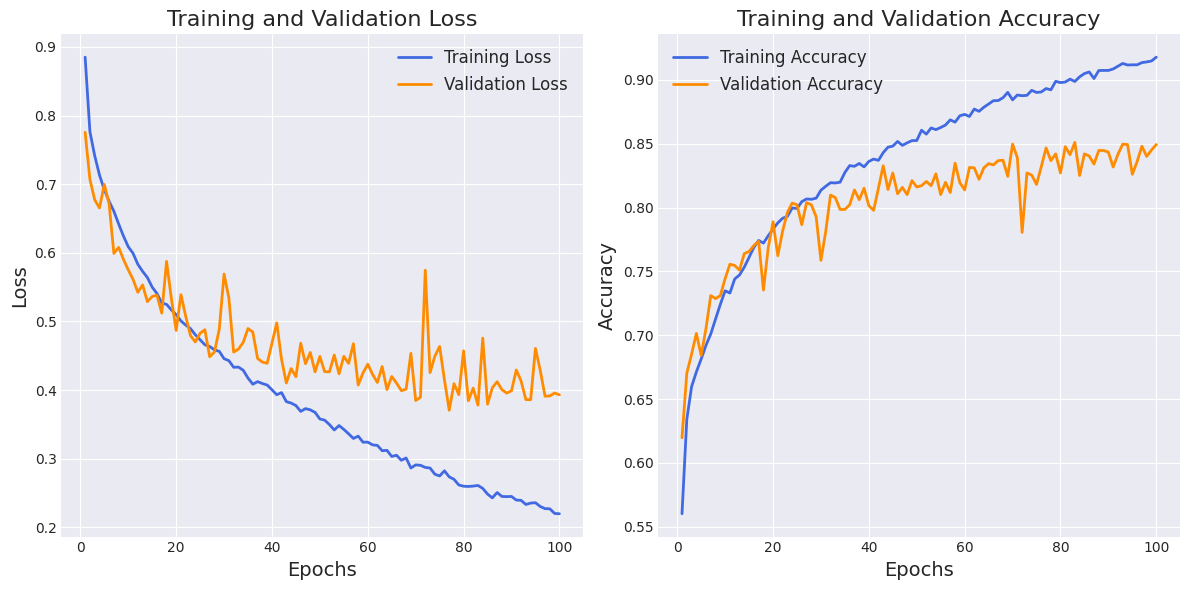

In [174]:
plot_history(history_kernel9)

En el caso de este experimento, se puede observar que el modelo entrenado con un `kernel_size=9` presenta una tendencia similar a los experimentos anteriores, donde el modelo alcanza un accuracy cercano a 0.90 en el conjunto de entrenamiento, pero no logra alcanzar el mismo valor en el conjunto de validación, obteniendo un valor de 0.8494. Al igual que en el experimento anterior, se puede observar que incrementar el tamaño del kernel ha afectado negativamente la capacidad de generalización del modelo.

In [179]:
results = evaluate_model(model_kernel9, testloader, selected_classes)

In [180]:
print(results['classification_report'])

              precision  recall  f1-score  support
cat                0.80    0.80      0.80  1000.00
dog                0.84    0.82      0.83  1000.00
frog               0.92    0.94      0.93  1000.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.85    0.85      0.85  3000.00
weighted avg       0.85    0.85      0.85  3000.00


En cuanto a las métricas de evaluación, se puede observar un mejor desempeño similar al expérimento anterior, con algunos cambios para las clases de gato, donde hay un incremento en la precisión y una disminución en el recall. En general, el modelo sigue mostrando un buen desempeño, pero se puede observar que el incremento del tamaño del kernel ha afectado negativamente la capacidad de discriminación entre clases del modelo en comparación al experimento con `kernel_size=5`.

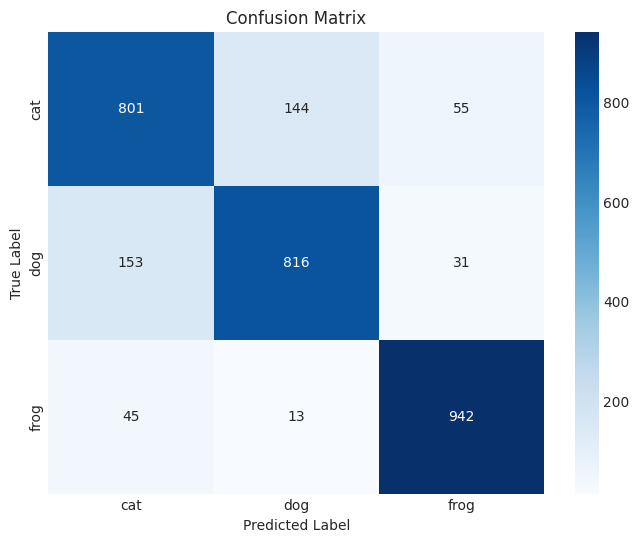

In [181]:
conf_matrix = results['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

En la matriz de confusión, se puede observar que el modelo ha logrado diferenciar mejor entre las clases de gato y perro en comparación al experimento con `kernel_size=7`, pero al mismo tiempo ha tenido más dificultades para diferenciar entre las clases de rana y perro, gato y rana. Por lo que se puede concluir que el incremento del tamaño del kernel ha afectado negativamente la capacidad de discriminación entre clases del modelo. Sin embargo, al menos para este entrenamiento, tiene un desempeño ligeramente más balanceado en comparación al experimento con `kernel_size=7`.

In [182]:
model_filename = save_model_with_metrics(model_kernel9, history_kernel9, path="models", filename_prefix="cifar10_cnn", kernel_size=9)

Model saved as models/cifar10_cnn_kernel9_loss0.39_acc0.85.pth


##  Experimento con tamaño de kernel 11x11

Finalmente, en esta sección se entrenará el modelo con un tamaño de kernel de 11x11 y se evaluará su comportamiento en términos de la pérdida y el *accuracy*.

In [183]:
model_kernel11 = CNN(kernel_size=11)
history_kernel11 = fit(model_kernel11, {'train': trainloader, 'test': testloader}, epochs=100)

Training Epoch 1/100: 100%|██████████| 938/938 [00:09<00:00, 104.07it/s]


Epoch 1/100 | Train Loss: 0.9014 | Train Acc: 0.5528 | Val Loss: 0.8761 | Val Acc: 0.5675


Training Epoch 2/100: 100%|██████████| 938/938 [00:09<00:00, 102.79it/s]


Epoch 2/100 | Train Loss: 0.7981 | Train Acc: 0.6199 | Val Loss: 0.7189 | Val Acc: 0.6616


Training Epoch 3/100: 100%|██████████| 938/938 [00:09<00:00, 103.67it/s]


Epoch 3/100 | Train Loss: 0.7629 | Train Acc: 0.6450 | Val Loss: 0.6993 | Val Acc: 0.6715


Training Epoch 4/100: 100%|██████████| 938/938 [00:08<00:00, 104.25it/s]


Epoch 4/100 | Train Loss: 0.7343 | Train Acc: 0.6569 | Val Loss: 0.6897 | Val Acc: 0.6752


Training Epoch 5/100: 100%|██████████| 938/938 [00:08<00:00, 104.82it/s]


Epoch 5/100 | Train Loss: 0.7155 | Train Acc: 0.6708 | Val Loss: 0.6753 | Val Acc: 0.6872


Training Epoch 6/100: 100%|██████████| 938/938 [00:08<00:00, 104.74it/s]


Epoch 6/100 | Train Loss: 0.6908 | Train Acc: 0.6854 | Val Loss: 0.7092 | Val Acc: 0.6749


Training Epoch 7/100: 100%|██████████| 938/938 [00:08<00:00, 105.69it/s]


Epoch 7/100 | Train Loss: 0.6851 | Train Acc: 0.6887 | Val Loss: 0.6554 | Val Acc: 0.6945


Training Epoch 8/100: 100%|██████████| 938/938 [00:08<00:00, 106.53it/s]


Epoch 8/100 | Train Loss: 0.6612 | Train Acc: 0.7012 | Val Loss: 0.6319 | Val Acc: 0.7108


Training Epoch 9/100: 100%|██████████| 938/938 [00:08<00:00, 107.14it/s]


Epoch 9/100 | Train Loss: 0.6544 | Train Acc: 0.7032 | Val Loss: 0.6406 | Val Acc: 0.7071


Training Epoch 10/100: 100%|██████████| 938/938 [00:08<00:00, 106.01it/s]


Epoch 10/100 | Train Loss: 0.6371 | Train Acc: 0.7170 | Val Loss: 0.6248 | Val Acc: 0.7184


Training Epoch 11/100: 100%|██████████| 938/938 [00:08<00:00, 111.25it/s]


Epoch 11/100 | Train Loss: 0.6270 | Train Acc: 0.7240 | Val Loss: 0.6294 | Val Acc: 0.7164


Training Epoch 12/100: 100%|██████████| 938/938 [00:08<00:00, 110.74it/s]


Epoch 12/100 | Train Loss: 0.6138 | Train Acc: 0.7292 | Val Loss: 0.5797 | Val Acc: 0.7397


Training Epoch 13/100: 100%|██████████| 938/938 [00:08<00:00, 110.79it/s]


Epoch 13/100 | Train Loss: 0.6020 | Train Acc: 0.7381 | Val Loss: 0.5731 | Val Acc: 0.7477


Training Epoch 14/100: 100%|██████████| 938/938 [00:08<00:00, 105.54it/s]


Epoch 14/100 | Train Loss: 0.5935 | Train Acc: 0.7413 | Val Loss: 0.6152 | Val Acc: 0.7201


Training Epoch 15/100: 100%|██████████| 938/938 [00:08<00:00, 106.20it/s]


Epoch 15/100 | Train Loss: 0.5847 | Train Acc: 0.7443 | Val Loss: 0.5411 | Val Acc: 0.7709


Training Epoch 16/100: 100%|██████████| 938/938 [00:08<00:00, 106.35it/s]


Epoch 16/100 | Train Loss: 0.5720 | Train Acc: 0.7510 | Val Loss: 0.6746 | Val Acc: 0.6961


Training Epoch 17/100: 100%|██████████| 938/938 [00:08<00:00, 106.48it/s]


Epoch 17/100 | Train Loss: 0.5653 | Train Acc: 0.7549 | Val Loss: 0.6080 | Val Acc: 0.7334


Training Epoch 18/100: 100%|██████████| 938/938 [00:08<00:00, 105.69it/s]


Epoch 18/100 | Train Loss: 0.5588 | Train Acc: 0.7576 | Val Loss: 0.5825 | Val Acc: 0.7430


Training Epoch 19/100: 100%|██████████| 938/938 [00:08<00:00, 106.28it/s]


Epoch 19/100 | Train Loss: 0.5512 | Train Acc: 0.7633 | Val Loss: 0.5814 | Val Acc: 0.7410


Training Epoch 20/100: 100%|██████████| 938/938 [00:08<00:00, 108.37it/s]


Epoch 20/100 | Train Loss: 0.5401 | Train Acc: 0.7674 | Val Loss: 0.5313 | Val Acc: 0.7650


Training Epoch 21/100: 100%|██████████| 938/938 [00:08<00:00, 109.99it/s]


Epoch 21/100 | Train Loss: 0.5337 | Train Acc: 0.7675 | Val Loss: 0.5827 | Val Acc: 0.7540


Training Epoch 22/100: 100%|██████████| 938/938 [00:08<00:00, 108.89it/s]


Epoch 22/100 | Train Loss: 0.5331 | Train Acc: 0.7738 | Val Loss: 0.5386 | Val Acc: 0.7543


Training Epoch 23/100: 100%|██████████| 938/938 [00:08<00:00, 110.00it/s]


Epoch 23/100 | Train Loss: 0.5220 | Train Acc: 0.7766 | Val Loss: 0.5288 | Val Acc: 0.7683


Training Epoch 24/100: 100%|██████████| 938/938 [00:08<00:00, 110.98it/s]


Epoch 24/100 | Train Loss: 0.5172 | Train Acc: 0.7774 | Val Loss: 0.5206 | Val Acc: 0.7633


Training Epoch 25/100: 100%|██████████| 938/938 [00:08<00:00, 111.13it/s]


Epoch 25/100 | Train Loss: 0.5073 | Train Acc: 0.7862 | Val Loss: 0.5186 | Val Acc: 0.7783


Training Epoch 26/100: 100%|██████████| 938/938 [00:08<00:00, 109.48it/s]


Epoch 26/100 | Train Loss: 0.4972 | Train Acc: 0.7907 | Val Loss: 0.4931 | Val Acc: 0.7862


Training Epoch 27/100: 100%|██████████| 938/938 [00:08<00:00, 110.93it/s]


Epoch 27/100 | Train Loss: 0.4957 | Train Acc: 0.7896 | Val Loss: 0.5184 | Val Acc: 0.7793


Training Epoch 28/100: 100%|██████████| 938/938 [00:08<00:00, 111.14it/s]


Epoch 28/100 | Train Loss: 0.4906 | Train Acc: 0.7920 | Val Loss: 0.5133 | Val Acc: 0.7746


Training Epoch 29/100: 100%|██████████| 938/938 [00:08<00:00, 111.21it/s]


Epoch 29/100 | Train Loss: 0.4881 | Train Acc: 0.7920 | Val Loss: 0.4924 | Val Acc: 0.7932


Training Epoch 30/100: 100%|██████████| 938/938 [00:08<00:00, 110.47it/s]


Epoch 30/100 | Train Loss: 0.4783 | Train Acc: 0.8026 | Val Loss: 0.5169 | Val Acc: 0.7789


Training Epoch 31/100: 100%|██████████| 938/938 [00:08<00:00, 110.78it/s]


Epoch 31/100 | Train Loss: 0.4748 | Train Acc: 0.8008 | Val Loss: 0.4837 | Val Acc: 0.7926


Training Epoch 32/100: 100%|██████████| 938/938 [00:08<00:00, 109.03it/s]


Epoch 32/100 | Train Loss: 0.4630 | Train Acc: 0.8056 | Val Loss: 0.5010 | Val Acc: 0.7803


Training Epoch 33/100: 100%|██████████| 938/938 [00:08<00:00, 110.36it/s]


Epoch 33/100 | Train Loss: 0.4618 | Train Acc: 0.8082 | Val Loss: 0.4959 | Val Acc: 0.7822


Training Epoch 34/100: 100%|██████████| 938/938 [00:08<00:00, 110.21it/s]


Epoch 34/100 | Train Loss: 0.4603 | Train Acc: 0.8080 | Val Loss: 0.4840 | Val Acc: 0.7932


Training Epoch 35/100: 100%|██████████| 938/938 [00:08<00:00, 110.64it/s]


Epoch 35/100 | Train Loss: 0.4515 | Train Acc: 0.8116 | Val Loss: 0.5081 | Val Acc: 0.7892


Training Epoch 36/100: 100%|██████████| 938/938 [00:08<00:00, 109.39it/s]


Epoch 36/100 | Train Loss: 0.4461 | Train Acc: 0.8136 | Val Loss: 0.4669 | Val Acc: 0.7975


Training Epoch 37/100: 100%|██████████| 938/938 [00:08<00:00, 111.44it/s]


Epoch 37/100 | Train Loss: 0.4498 | Train Acc: 0.8123 | Val Loss: 0.5009 | Val Acc: 0.7916


Training Epoch 38/100: 100%|██████████| 938/938 [00:08<00:00, 110.43it/s]


Epoch 38/100 | Train Loss: 0.4400 | Train Acc: 0.8157 | Val Loss: 0.4441 | Val Acc: 0.8135


Training Epoch 39/100: 100%|██████████| 938/938 [00:08<00:00, 111.05it/s]


Epoch 39/100 | Train Loss: 0.4284 | Train Acc: 0.8248 | Val Loss: 0.5258 | Val Acc: 0.7852


Training Epoch 40/100: 100%|██████████| 938/938 [00:08<00:00, 106.07it/s]


Epoch 40/100 | Train Loss: 0.4327 | Train Acc: 0.8208 | Val Loss: 0.4531 | Val Acc: 0.8122


Training Epoch 41/100: 100%|██████████| 938/938 [00:08<00:00, 107.07it/s]


Epoch 41/100 | Train Loss: 0.4296 | Train Acc: 0.8235 | Val Loss: 0.4570 | Val Acc: 0.8039


Training Epoch 42/100: 100%|██████████| 938/938 [00:08<00:00, 106.94it/s]


Epoch 42/100 | Train Loss: 0.4244 | Train Acc: 0.8234 | Val Loss: 0.4691 | Val Acc: 0.7992


Training Epoch 43/100: 100%|██████████| 938/938 [00:08<00:00, 106.92it/s]


Epoch 43/100 | Train Loss: 0.4222 | Train Acc: 0.8260 | Val Loss: 0.4689 | Val Acc: 0.7999


Training Epoch 44/100: 100%|██████████| 938/938 [00:08<00:00, 105.38it/s]


Epoch 44/100 | Train Loss: 0.4107 | Train Acc: 0.8300 | Val Loss: 0.4950 | Val Acc: 0.7892


Training Epoch 45/100: 100%|██████████| 938/938 [00:08<00:00, 106.97it/s]


Epoch 45/100 | Train Loss: 0.4090 | Train Acc: 0.8343 | Val Loss: 0.4733 | Val Acc: 0.8062


Training Epoch 46/100: 100%|██████████| 938/938 [00:08<00:00, 107.25it/s]


Epoch 46/100 | Train Loss: 0.4091 | Train Acc: 0.8334 | Val Loss: 0.5045 | Val Acc: 0.7822


Training Epoch 47/100: 100%|██████████| 938/938 [00:08<00:00, 107.02it/s]


Epoch 47/100 | Train Loss: 0.3974 | Train Acc: 0.8361 | Val Loss: 0.4758 | Val Acc: 0.7942


Training Epoch 48/100: 100%|██████████| 938/938 [00:08<00:00, 106.77it/s]


Epoch 48/100 | Train Loss: 0.3942 | Train Acc: 0.8378 | Val Loss: 0.4752 | Val Acc: 0.7856


Training Epoch 49/100: 100%|██████████| 938/938 [00:08<00:00, 109.07it/s]


Epoch 49/100 | Train Loss: 0.3955 | Train Acc: 0.8380 | Val Loss: 0.4620 | Val Acc: 0.8045


Training Epoch 50/100: 100%|██████████| 938/938 [00:08<00:00, 111.51it/s]


Epoch 50/100 | Train Loss: 0.3902 | Train Acc: 0.8415 | Val Loss: 0.5833 | Val Acc: 0.7713


Training Epoch 51/100: 100%|██████████| 938/938 [00:08<00:00, 110.85it/s]


Epoch 51/100 | Train Loss: 0.3835 | Train Acc: 0.8452 | Val Loss: 0.4534 | Val Acc: 0.8042


Training Epoch 52/100: 100%|██████████| 938/938 [00:08<00:00, 110.04it/s]


Epoch 52/100 | Train Loss: 0.3833 | Train Acc: 0.8445 | Val Loss: 0.4275 | Val Acc: 0.8248


Training Epoch 53/100: 100%|██████████| 938/938 [00:08<00:00, 107.31it/s]


Epoch 53/100 | Train Loss: 0.3795 | Train Acc: 0.8444 | Val Loss: 0.4464 | Val Acc: 0.8118


Training Epoch 54/100: 100%|██████████| 938/938 [00:08<00:00, 105.96it/s]


Epoch 54/100 | Train Loss: 0.3743 | Train Acc: 0.8496 | Val Loss: 0.4387 | Val Acc: 0.8168


Training Epoch 55/100: 100%|██████████| 938/938 [00:08<00:00, 106.64it/s]


Epoch 55/100 | Train Loss: 0.3715 | Train Acc: 0.8496 | Val Loss: 0.4773 | Val Acc: 0.8055


Training Epoch 56/100: 100%|██████████| 938/938 [00:08<00:00, 104.23it/s]


Epoch 56/100 | Train Loss: 0.3666 | Train Acc: 0.8559 | Val Loss: 0.4327 | Val Acc: 0.8125


Training Epoch 57/100: 100%|██████████| 938/938 [00:09<00:00, 96.92it/s] 


Epoch 57/100 | Train Loss: 0.3663 | Train Acc: 0.8547 | Val Loss: 0.4629 | Val Acc: 0.8005


Training Epoch 58/100: 100%|██████████| 938/938 [00:08<00:00, 106.50it/s]


Epoch 58/100 | Train Loss: 0.3615 | Train Acc: 0.8549 | Val Loss: 0.4348 | Val Acc: 0.8182


Training Epoch 59/100: 100%|██████████| 938/938 [00:08<00:00, 108.13it/s]


Epoch 59/100 | Train Loss: 0.3571 | Train Acc: 0.8556 | Val Loss: 0.4403 | Val Acc: 0.8162


Training Epoch 60/100: 100%|██████████| 938/938 [00:08<00:00, 110.69it/s]


Epoch 60/100 | Train Loss: 0.3566 | Train Acc: 0.8547 | Val Loss: 0.4453 | Val Acc: 0.8105


Training Epoch 61/100: 100%|██████████| 938/938 [00:08<00:00, 109.03it/s]


Epoch 61/100 | Train Loss: 0.3448 | Train Acc: 0.8631 | Val Loss: 0.4393 | Val Acc: 0.8188


Training Epoch 62/100: 100%|██████████| 938/938 [00:08<00:00, 111.22it/s]


Epoch 62/100 | Train Loss: 0.3442 | Train Acc: 0.8625 | Val Loss: 0.4136 | Val Acc: 0.8318


Training Epoch 63/100: 100%|██████████| 938/938 [00:08<00:00, 111.25it/s]


Epoch 63/100 | Train Loss: 0.3478 | Train Acc: 0.8608 | Val Loss: 0.4407 | Val Acc: 0.8168


Training Epoch 64/100: 100%|██████████| 938/938 [00:08<00:00, 111.60it/s]


Epoch 64/100 | Train Loss: 0.3377 | Train Acc: 0.8653 | Val Loss: 0.4533 | Val Acc: 0.8142


Training Epoch 65/100: 100%|██████████| 938/938 [00:08<00:00, 111.10it/s]


Epoch 65/100 | Train Loss: 0.3430 | Train Acc: 0.8621 | Val Loss: 0.4465 | Val Acc: 0.8122


Training Epoch 66/100: 100%|██████████| 938/938 [00:08<00:00, 110.93it/s]


Epoch 66/100 | Train Loss: 0.3313 | Train Acc: 0.8688 | Val Loss: 0.4340 | Val Acc: 0.8208


Training Epoch 67/100: 100%|██████████| 938/938 [00:08<00:00, 111.09it/s]


Epoch 67/100 | Train Loss: 0.3278 | Train Acc: 0.8667 | Val Loss: 0.4411 | Val Acc: 0.8255


Training Epoch 68/100: 100%|██████████| 938/938 [00:08<00:00, 111.20it/s]


Epoch 68/100 | Train Loss: 0.3285 | Train Acc: 0.8715 | Val Loss: 0.4487 | Val Acc: 0.8138


Training Epoch 69/100: 100%|██████████| 938/938 [00:08<00:00, 110.73it/s]


Epoch 69/100 | Train Loss: 0.3262 | Train Acc: 0.8734 | Val Loss: 0.4442 | Val Acc: 0.8208


Training Epoch 70/100: 100%|██████████| 938/938 [00:08<00:00, 110.94it/s]


Epoch 70/100 | Train Loss: 0.3194 | Train Acc: 0.8750 | Val Loss: 0.4432 | Val Acc: 0.8178


Training Epoch 71/100: 100%|██████████| 938/938 [00:08<00:00, 111.41it/s]


Epoch 71/100 | Train Loss: 0.3194 | Train Acc: 0.8738 | Val Loss: 0.4122 | Val Acc: 0.8255


Training Epoch 72/100: 100%|██████████| 938/938 [00:08<00:00, 111.29it/s]


Epoch 72/100 | Train Loss: 0.3188 | Train Acc: 0.8717 | Val Loss: 0.4671 | Val Acc: 0.8105


Training Epoch 73/100: 100%|██████████| 938/938 [00:08<00:00, 110.49it/s]


Epoch 73/100 | Train Loss: 0.3147 | Train Acc: 0.8767 | Val Loss: 0.4380 | Val Acc: 0.8205


Training Epoch 74/100: 100%|██████████| 938/938 [00:08<00:00, 110.56it/s]


Epoch 74/100 | Train Loss: 0.3102 | Train Acc: 0.8786 | Val Loss: 0.4409 | Val Acc: 0.8265


Training Epoch 75/100: 100%|██████████| 938/938 [00:08<00:00, 111.07it/s]


Epoch 75/100 | Train Loss: 0.3040 | Train Acc: 0.8803 | Val Loss: 0.4299 | Val Acc: 0.8311


Training Epoch 76/100: 100%|██████████| 938/938 [00:08<00:00, 111.13it/s]


Epoch 76/100 | Train Loss: 0.3063 | Train Acc: 0.8823 | Val Loss: 0.4279 | Val Acc: 0.8338


Training Epoch 77/100: 100%|██████████| 938/938 [00:08<00:00, 111.22it/s]


Epoch 77/100 | Train Loss: 0.3019 | Train Acc: 0.8826 | Val Loss: 0.4498 | Val Acc: 0.8205


Training Epoch 78/100: 100%|██████████| 938/938 [00:08<00:00, 107.70it/s]


Epoch 78/100 | Train Loss: 0.2972 | Train Acc: 0.8825 | Val Loss: 0.4102 | Val Acc: 0.8298


Training Epoch 79/100: 100%|██████████| 938/938 [00:08<00:00, 105.25it/s]


Epoch 79/100 | Train Loss: 0.2895 | Train Acc: 0.8863 | Val Loss: 0.4212 | Val Acc: 0.8358


Training Epoch 80/100: 100%|██████████| 938/938 [00:08<00:00, 105.34it/s]


Epoch 80/100 | Train Loss: 0.2973 | Train Acc: 0.8823 | Val Loss: 0.4259 | Val Acc: 0.8261


Training Epoch 81/100: 100%|██████████| 938/938 [00:08<00:00, 105.86it/s]


Epoch 81/100 | Train Loss: 0.2912 | Train Acc: 0.8859 | Val Loss: 0.4475 | Val Acc: 0.8231


Training Epoch 82/100: 100%|██████████| 938/938 [00:08<00:00, 106.89it/s]


Epoch 82/100 | Train Loss: 0.2887 | Train Acc: 0.8909 | Val Loss: 0.4039 | Val Acc: 0.8354


Training Epoch 83/100: 100%|██████████| 938/938 [00:08<00:00, 106.27it/s]


Epoch 83/100 | Train Loss: 0.2919 | Train Acc: 0.8865 | Val Loss: 0.5144 | Val Acc: 0.8032


Training Epoch 84/100: 100%|██████████| 938/938 [00:08<00:00, 106.11it/s]


Epoch 84/100 | Train Loss: 0.2834 | Train Acc: 0.8887 | Val Loss: 0.4340 | Val Acc: 0.8228


Training Epoch 85/100: 100%|██████████| 938/938 [00:08<00:00, 106.10it/s]


Epoch 85/100 | Train Loss: 0.2746 | Train Acc: 0.8925 | Val Loss: 0.4940 | Val Acc: 0.8138


Training Epoch 86/100: 100%|██████████| 938/938 [00:08<00:00, 105.91it/s]


Epoch 86/100 | Train Loss: 0.2815 | Train Acc: 0.8911 | Val Loss: 0.4331 | Val Acc: 0.8215


Training Epoch 87/100: 100%|██████████| 938/938 [00:08<00:00, 106.67it/s]


Epoch 87/100 | Train Loss: 0.2804 | Train Acc: 0.8910 | Val Loss: 0.4216 | Val Acc: 0.8358


Training Epoch 88/100: 100%|██████████| 938/938 [00:08<00:00, 110.90it/s]


Epoch 88/100 | Train Loss: 0.2789 | Train Acc: 0.8903 | Val Loss: 0.4295 | Val Acc: 0.8285


Training Epoch 89/100: 100%|██████████| 938/938 [00:08<00:00, 110.14it/s]


Epoch 89/100 | Train Loss: 0.2739 | Train Acc: 0.8973 | Val Loss: 0.4838 | Val Acc: 0.8132


Training Epoch 90/100: 100%|██████████| 938/938 [00:08<00:00, 111.63it/s]


Epoch 90/100 | Train Loss: 0.2716 | Train Acc: 0.8956 | Val Loss: 0.4244 | Val Acc: 0.8298


Training Epoch 91/100: 100%|██████████| 938/938 [00:08<00:00, 106.99it/s]


Epoch 91/100 | Train Loss: 0.2600 | Train Acc: 0.8997 | Val Loss: 0.4705 | Val Acc: 0.8261


Training Epoch 92/100: 100%|██████████| 938/938 [00:08<00:00, 107.17it/s]


Epoch 92/100 | Train Loss: 0.2632 | Train Acc: 0.9001 | Val Loss: 0.4345 | Val Acc: 0.8275


Training Epoch 93/100: 100%|██████████| 938/938 [00:08<00:00, 107.39it/s]


Epoch 93/100 | Train Loss: 0.2608 | Train Acc: 0.9007 | Val Loss: 0.4365 | Val Acc: 0.8281


Training Epoch 94/100: 100%|██████████| 938/938 [00:08<00:00, 107.06it/s]


Epoch 94/100 | Train Loss: 0.2668 | Train Acc: 0.8974 | Val Loss: 0.4230 | Val Acc: 0.8308


Training Epoch 95/100: 100%|██████████| 938/938 [00:08<00:00, 107.70it/s]


Epoch 95/100 | Train Loss: 0.2522 | Train Acc: 0.9047 | Val Loss: 0.4518 | Val Acc: 0.8238


Training Epoch 96/100: 100%|██████████| 938/938 [00:08<00:00, 106.70it/s]


Epoch 96/100 | Train Loss: 0.2543 | Train Acc: 0.9039 | Val Loss: 0.4490 | Val Acc: 0.8328


Training Epoch 97/100: 100%|██████████| 938/938 [00:08<00:00, 107.84it/s]


Epoch 97/100 | Train Loss: 0.2519 | Train Acc: 0.9025 | Val Loss: 0.4508 | Val Acc: 0.8201


Training Epoch 98/100: 100%|██████████| 938/938 [00:08<00:00, 109.07it/s]


Epoch 98/100 | Train Loss: 0.2442 | Train Acc: 0.9062 | Val Loss: 0.4268 | Val Acc: 0.8281


Training Epoch 99/100: 100%|██████████| 938/938 [00:08<00:00, 109.36it/s]


Epoch 99/100 | Train Loss: 0.2520 | Train Acc: 0.9027 | Val Loss: 0.4618 | Val Acc: 0.8168


Training Epoch 100/100: 100%|██████████| 938/938 [00:08<00:00, 109.17it/s]
                                                              

Epoch 100/100 | Train Loss: 0.2501 | Train Acc: 0.9057 | Val Loss: 0.4440 | Val Acc: 0.8231


/tmp/ipykernel_2685/1010231979.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


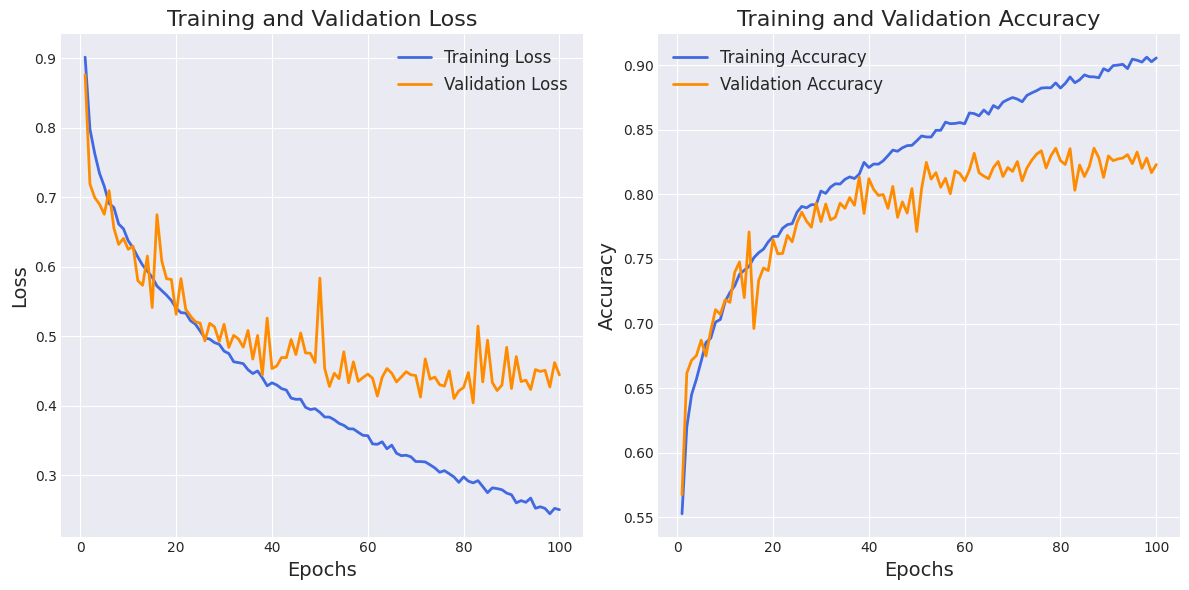

In [184]:
plot_history(history_kernel11)

En las gráficas se puede ver que incrementar el tamaño del kernel a 11x11 ha afectado en mayor medida la capacidad de generalización del modelo, donde el modelo alcanza un accuracy cercano a 0.90 en el conjunto de entrenamiento, pero no logra alcanzar el mismo valor en el conjunto de validación, obteniendo un valor de 0.8231, mucho más bajo que los experimentos anterior, e incluso se ha hecho visualmente más notorio el sobreajuste del modelo a los datos de entrenamiento.

In [189]:
results = evaluate_model(model_kernel11, testloader, selected_classes)

In [190]:
print(results['classification_report'])

              precision  recall  f1-score  support
cat                0.73    0.85      0.78  1000.00
dog                0.84    0.78      0.81  1000.00
frog               0.96    0.87      0.91  1000.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.84    0.83      0.83  3000.00
weighted avg       0.84    0.83      0.83  3000.00


Se puede ver en las métricas de evaluación el impacto negativo del incremento del tamaño del kernel, donde se obtienen valores más bajos en comparación a los experimentos anteriores. 

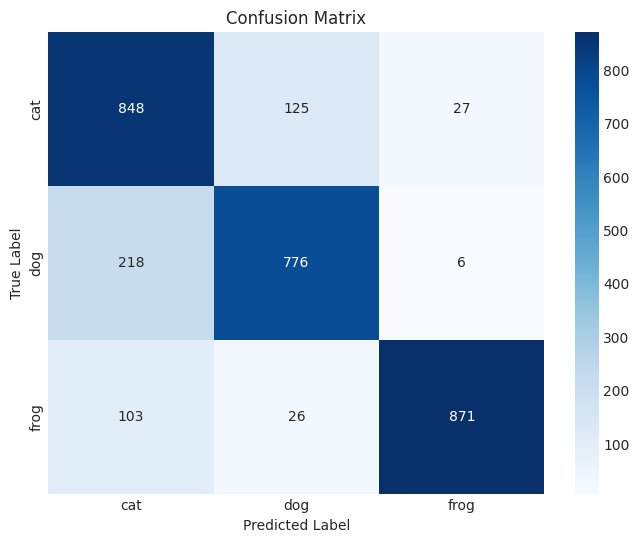

In [191]:
conf_matrix = results['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

En la matriz de confusión también se puede observar que el modelo ha tenido más dificultades para diferenciar entre las diferentes clases.

In [188]:
model_filename = save_model_with_metrics(model_kernel11, history_kernel11, path="models", filename_prefix="cifar10_cnn", kernel_size=11)

Model saved as models/cifar10_cnn_kernel11_loss0.44_acc0.82.pth


## Conclusiones

En los experimentos realizados, se observó que el modelo con un tamaño de **kernel de 5x5 obtiene el mejor desempeño en términos de accuracy en el conjunto de validación**. Aunque los modelos con tamaños de kernel más grandes también lograron métricas razonables, se identificó una tendencia general: **a medida que el tamaño del kernel aumenta, el desempeño del modelo tiende a disminuir, lo que afecta negativamente su capacidad de generalización**.

Este comportamiento podría deberse a que al incrementar el tamaño del kernel en las capas convolucionales, el modelo comienza a considerar regiones más grandes de la imagen. De esta forma, el modelo estaría capturando patrones más globales, pero perdiendo detalles locales que podrían ser importantes para la diferenciación entre clases. Además, un tamaño de kernel mayor incrementa el número de parámetros entrenables, lo que aumenta la complejidad del modelo y, con ello, el riesgo de sobreajuste.

# Parte 2b - Transfer Learning

Empleando el modelo entrenado y elegido por Ud. en el punto anterior, realice transfer learning para indentificar del mismo dataset CIFAR10 las clases ['plane', 'car'].

Compare la evolución de la función de perdida y accuracy realizando transfer learning vs entrenando el modelo desde cero.

Compare los resultados finales y comente.

## Generar dataset con las clases seleccionadas

Se seleccionan 2 clases: avión, automóvil

In [198]:
classes = original_train_dataset.classes
selected_classes = ['airplane', 'automobile']
selected_class_indices = [classes.index(cls) for cls in selected_classes]

Se creará un nuevo conjunto de datos con las clases seleccionadas

In [199]:
filtered_train_dataset = FilteredDataset(original_train_dataset, selected_class_indices)
filtered_test_dataset = FilteredDataset(original_test_dataset, selected_class_indices)

Se visualiza el tamaño de los conjuntos de datos

In [200]:
print(f'Original train dataset: {len(original_train_dataset)} images')
print(f'Filtered train dataset: {len(filtered_train_dataset)} images')

Original train dataset: 50000 images
Filtered train dataset: 10000 images


In [201]:
print(f'Original test dataset: {len(original_test_dataset)} images')
print(f'Filtered test dataset: {len(filtered_test_dataset)} images')

Original test dataset: 10000 images
Filtered test dataset: 2000 images


Se crean `DataLoaders` para los nuevos datasets con un tamaño de batch de 64

In [202]:
# Define the batch size
batch_size = 16

# Create DataLoaders for the new datasets
trainloader = DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Se genera un lote de imágenes y se las muestra

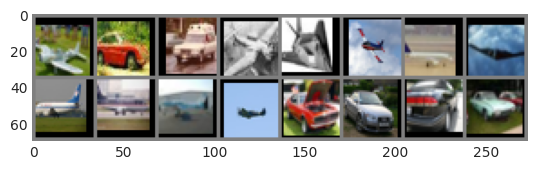

airplane automobile automobile airplane airplane airplane airplane airplane airplane airplane airplane airplane automobile automobile automobile automobile


In [206]:
# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display images from the batch
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{selected_classes[labels[j]]}' for j in range(batch_size)))

## Aplicar transfer learning

Se carga el modelo entrenado con el dataset anterior

In [299]:
# Load the model
transfer_model = CNN()
transfer_model.load_state_dict(torch.load('models/cifar10_cnn_kernel5_loss0.32_acc0.87.pth', weights_only=True))

<All keys matched successfully>

Se utiliza el modelo preentrenado para realizar transfer learning, pero se modifica la última capa para adaptarla a las nuevas clases

In [300]:
transfer_model.linear2

Linear(in_features=64, out_features=3, bias=True)

In [303]:
# Change the number of output classes
transfer_model.linear2 = torch.nn.Linear(64, 2)
transfer_model.to(device)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.

In [304]:
history_transfer = fit(transfer_model, {'train': trainloader, 'test': testloader}, epochs=3)

Training Epoch 1/3: 100%|██████████| 625/625 [00:03<00:00, 158.66it/s]


Epoch 1/3 | Train Loss: 0.2582 | Train Acc: 0.8974 | Val Loss: 0.1236 | Val Acc: 0.9585


Training Epoch 2/3: 100%|██████████| 625/625 [00:03<00:00, 183.82it/s]


Epoch 2/3 | Train Loss: 0.1363 | Train Acc: 0.9507 | Val Loss: 0.0955 | Val Acc: 0.9685


Training Epoch 3/3: 100%|██████████| 625/625 [00:03<00:00, 187.08it/s]
                                                              

Epoch 3/3 | Train Loss: 0.1141 | Train Acc: 0.9593 | Val Loss: 0.0961 | Val Acc: 0.9640


/tmp/ipykernel_2685/1010231979.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


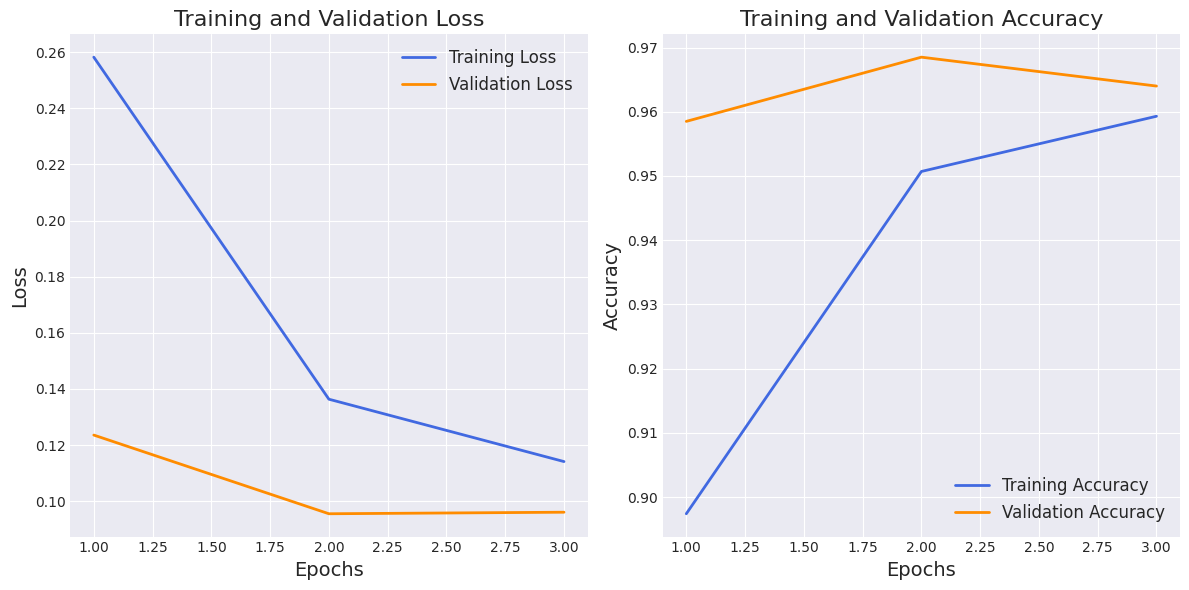

In [305]:
plot_history(history_transfer)

En las gráficas de arriba, se muestra la evolución de la pérdida y el *accuracy* en el conjunto de entrenamiento y validación durante el entrenamiento del modelo con transfer learning. Como se puede observar, solo son necesarios 3 epochs para que el modelo alcance un *accuracy* de 0.95 para el conjunto de entrenamiento y 0.96 para el conjunto de validación. 

Se calculan métricas de evaluación para el modelo con transfer learning

In [314]:
results = evaluate_model(transfer_model, testloader, selected_classes)

print(results['classification_report'])

              precision  recall  f1-score  support
airplane           0.94    0.98      0.96  1000.00
automobile         0.98    0.94      0.96  1000.00
accuracy           0.96    0.96      0.96     0.96
macro avg          0.96    0.96      0.96  2000.00
weighted avg       0.96    0.96      0.96  2000.00


Se puede ver en las métricas de evaluación que el modelo con transfer learning ha obtenido un desempeño muy bueno. En particular, se ha alcanzado un *accuracy* de 0.96. Además, se obtienen valores altos para las métricas de recall, precisión y F1-score, lo que indica que el modelo ha aprendido a diferenciar bien entre las clases de avión y automóvil.

También se muestra la matriz de confusión para el modelo con transfer learning

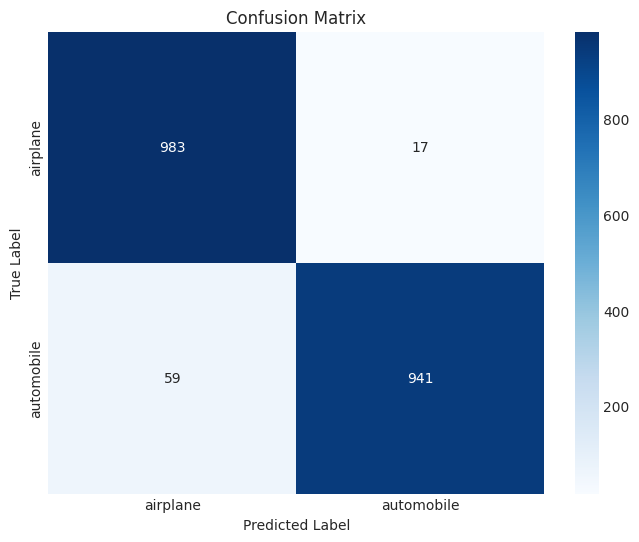

In [315]:
conf_matrix = results['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Se puede ver que la tasa de aciertos es muy alta para ambas clases, lo que apoya el argumento anterior de que el modelo ha aprendido a diferenciar bien entre las clases de avión y automóvil, mostrando un bajo número de clasificaciones incorrectas.

In [316]:
model_filename = save_model_with_metrics(base_model, history_transfer, path="models", filename_prefix="cifar10_transfer_cnn", kernel_size=5)

Model saved as models/cifar10_transfer_cnn_kernel5_loss0.10_acc0.96.pth


## Comparación con el entrenamiento desde cero

Para comparar el desempeño del modelo con transfer learning con el de un modelo entrenado desde cero, se entrenará un nuevo modelo con la misma arquitectura pero con las clases `airplane` y `automobile` desde cero.

Para eso se inicializa el modelo con la misma arquitectura utilizada anteriormente, pero esta vez no se cargan los pesos preentrenados y se pasa directamente a modificar la última capa para adaptarla a las nuevas clases.

In [323]:
# Load the model
scratch_model = CNN()

# Change the number of output classes
scratch_model.linear2 = torch.nn.Linear(64, 2)
scratch_model.to(device)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.

Se aplicará la función de evaluación solo para verificar que el modelo parte desde cero.

In [324]:
results = evaluate_model(scratch_model, testloader, selected_classes)

print(results['classification_report'])

              precision  recall  f1-score  support
airplane           0.50     1.0      0.67   1000.0
automobile         0.00     0.0      0.00   1000.0
accuracy           0.50     0.5      0.50      0.5
macro avg          0.25     0.5      0.33   2000.0
weighted avg       0.25     0.5      0.33   2000.0


Como se puede ver en las métricas de evaluación, el modelo en este punto tiene un comportamiento aleatorio, lo cual demuestra que el modelo no parte con un conocimiento previo de las clases de avión y automóvil.

A continuación, se entrenará el modelo desde cero 

In [325]:
history_scratch = fit(scratch_model, {'train': trainloader, 'test': testloader}, epochs=10)

Training Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 171.55it/s]


Epoch 1/10 | Train Loss: 0.4129 | Train Acc: 0.8125 | Val Loss: 0.3534 | Val Acc: 0.8350


Training Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 190.24it/s]


Epoch 2/10 | Train Loss: 0.2962 | Train Acc: 0.8760 | Val Loss: 0.2262 | Val Acc: 0.9105


Training Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 173.27it/s]


Epoch 3/10 | Train Loss: 0.2381 | Train Acc: 0.9022 | Val Loss: 0.1698 | Val Acc: 0.9340


Training Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 179.96it/s]


Epoch 4/10 | Train Loss: 0.2027 | Train Acc: 0.9183 | Val Loss: 0.1466 | Val Acc: 0.9480


Training Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 191.01it/s]


Epoch 5/10 | Train Loss: 0.1838 | Train Acc: 0.9259 | Val Loss: 0.1579 | Val Acc: 0.9345


Training Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 184.39it/s]


Epoch 6/10 | Train Loss: 0.1747 | Train Acc: 0.9334 | Val Loss: 0.1344 | Val Acc: 0.9530


Training Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 180.87it/s]


Epoch 7/10 | Train Loss: 0.1487 | Train Acc: 0.9407 | Val Loss: 0.1234 | Val Acc: 0.9520


Training Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 188.94it/s]


Epoch 8/10 | Train Loss: 0.1435 | Train Acc: 0.9442 | Val Loss: 0.1257 | Val Acc: 0.9505


Training Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 190.55it/s]


Epoch 9/10 | Train Loss: 0.1354 | Train Acc: 0.9488 | Val Loss: 0.1159 | Val Acc: 0.9550


Training Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 185.79it/s]
                                                             

Epoch 10/10 | Train Loss: 0.1333 | Train Acc: 0.9498 | Val Loss: 0.1203 | Val Acc: 0.9575


/tmp/ipykernel_2685/1010231979.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


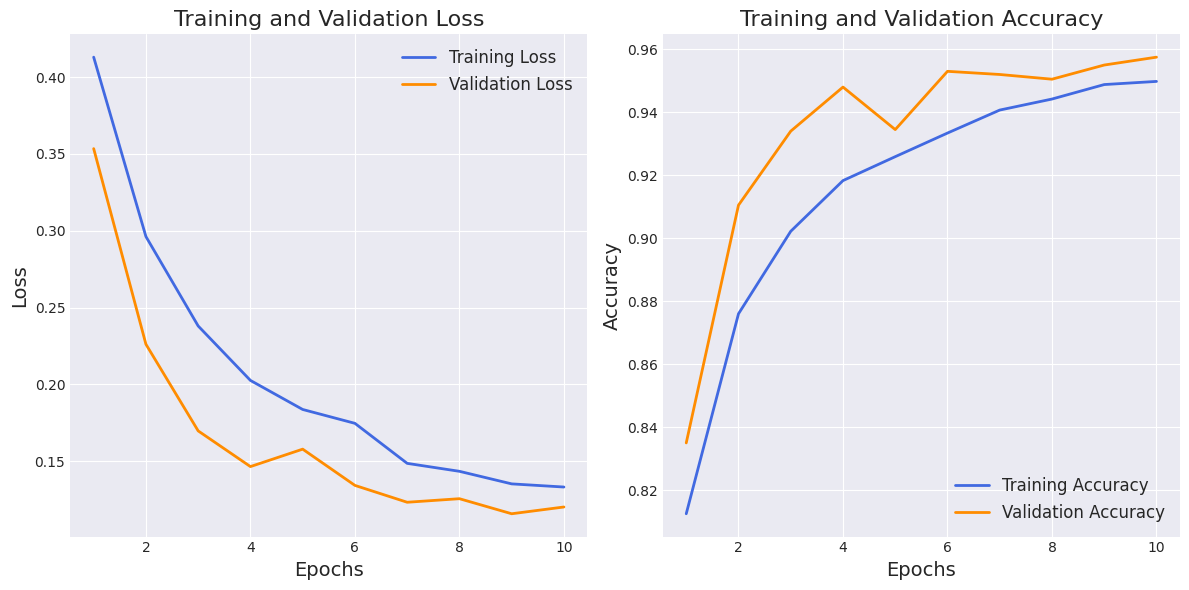

In [326]:
plot_history(history_scratch)

En las gráficas de la celda superior, se muestra la evolución de la pérdida y el *accuracy* en el conjunto de entrenamiento y validación durante el entrenamiento del modelo desde cero. Como se puede observar, en este caso se necesitan más epochs para que el modelo alcance un *accuracy* de 0.95 para el conjunto de entrenamiento y 0.96 para el conjunto de validación. 

A continuación, se vuelven a calcular las métricas de evaluación para el modelo ya entrenado 

In [327]:
results = evaluate_model(scratch_model, testloader, selected_classes)

print(results['classification_report'])

              precision  recall  f1-score  support
airplane           0.97    0.94      0.95  1000.00
automobile         0.94    0.97      0.95  1000.00
accuracy           0.95    0.95      0.95     0.95
macro avg          0.95    0.95      0.95  2000.00
weighted avg       0.95    0.95      0.95  2000.00


Las métricas de evaluación muestran que el aprendizaje del modelo incluso desde cero ha sido efectivo, obteniendo un *accuracy* de 0.95. Además, se obtienen valores altos para las métricas de recall, precisión y F1-score, lo que indica que este modelo también ha aprendido a diferenciar bien entre las clases de avión y automóvil.

También se muestra la matriz de confusión 

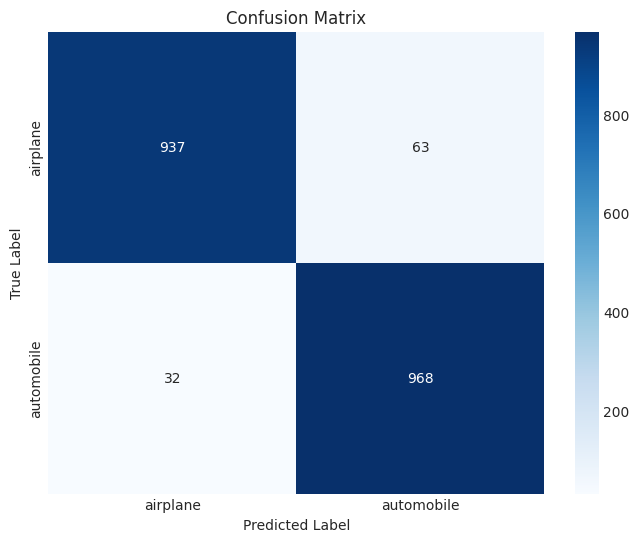

In [328]:
conf_matrix = results['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Se mantiene una buena capacidad de diferenciación entre las clases de avión y automóvil, mostrando un bajo número de clasificaciones incorrectas.

In [329]:
model_filename = save_model_with_metrics(scratch_model, history_scratch, path="models", filename_prefix="cifar10_scratch_cnn", kernel_size=5)

Model saved as models/cifar10_scratch_cnn_kernel5_loss0.12_acc0.96.pth


En la siguiente función se busca mostrar ambas gráficas de pérdida y accuracy para ambos modelos, con el fin de comparar su desempeño.

In [330]:
def compare_histories(history1, history2, title1='Model 1', title2='Model 2'):
    """
    Compare the training and validation metrics of two models.
    
    Parameters:
    - history1: Dictionary with the metrics of the first model (transfer learning).
    - history2: Dictionary with the metrics of the second model (from scratch).
    - title1: Title for the first model.
    - title2: Title for the second model.
    """
    # Get the number of epochs
    epochs1 = range(1, len(history1['train_loss']) + 1)
    epochs2 = range(1, len(history2['train_loss']) + 1)
    
    plt.figure(figsize=(12, 10))

    # Loss Comparison
    plt.subplot(2, 2, 1)
    plt.plot(epochs1, history1['train_loss'], label='Training Loss')
    plt.plot(epochs1, history1['val_loss'], label='Validation Loss')
    plt.title(f'{title1} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs2, history2['train_loss'], label='Training Loss')
    plt.plot(epochs2, history2['val_loss'], label='Validation Loss')
    plt.title(f'{title2} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Comparison
    plt.subplot(2, 2, 3)
    plt.plot(epochs1, history1['train_acc'], label='Training Accuracy')
    plt.plot(epochs1, history1['val_acc'], label='Validation Accuracy')
    plt.title(f'{title1} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(epochs2, history2['train_acc'], label='Training Accuracy')
    plt.plot(epochs2, history2['val_acc'], label='Validation Accuracy')
    plt.title(f'{title2} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

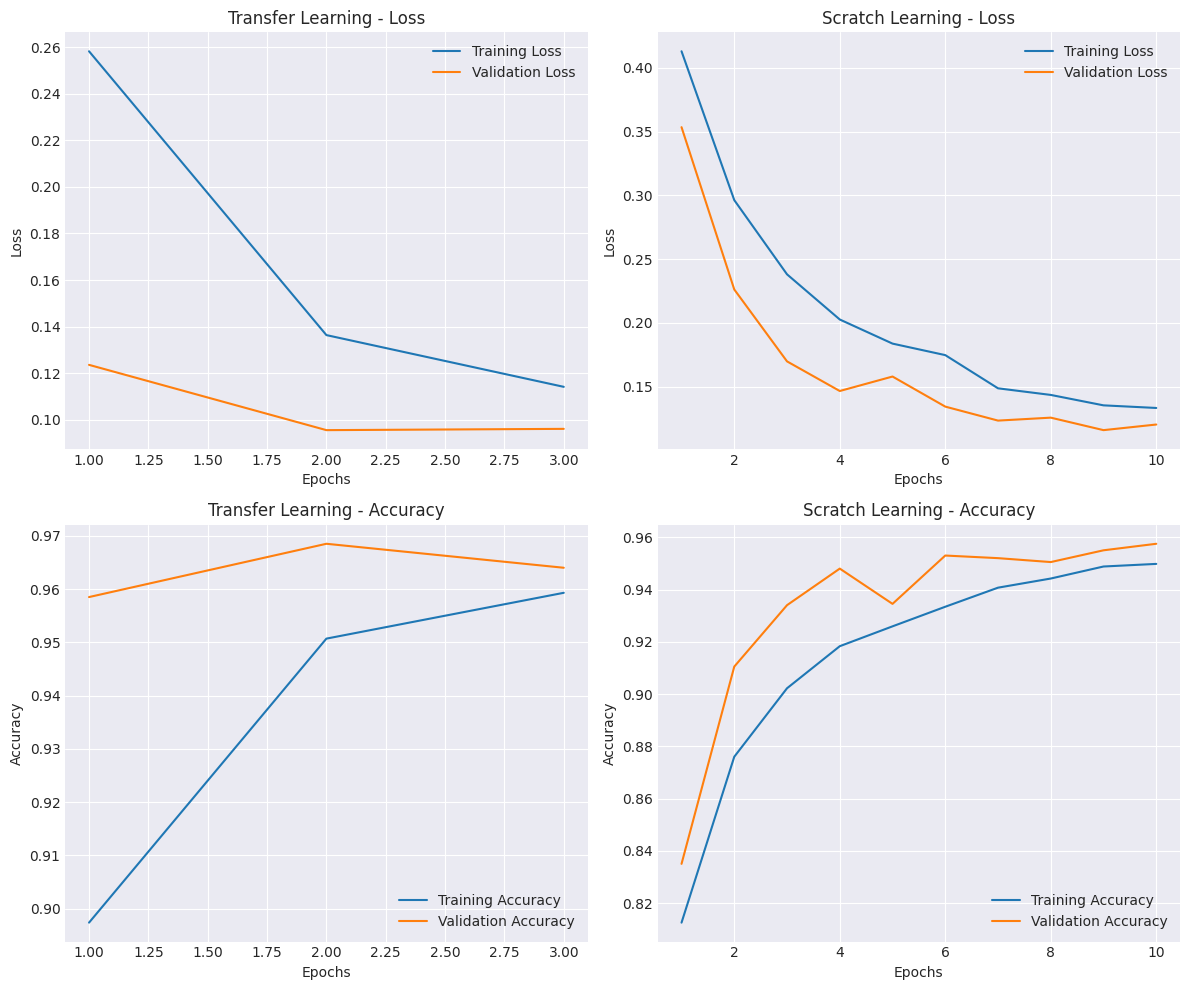

In [331]:
compare_histories(history_transfer, history_scratch, title1='Transfer Learning', title2='Scratch Learning')

En las imágenes anteriores, se pueden observar los gráficos de entrenamiento de los modelos con **transfer learning** y **entrenado desde cero**. Como se puede ver, ambos modelos alcanzan un *accuracy* cercano a 0.96 en el conjunto de validación, lo que indica que ambos modelos tienen un buen desempeño en la clasificación de las clases `airplane` y `automobile`. Sin embargo, el modelo con transfer learning alcanza este desempeño en menos epochs que el modelo entrenado desde cero. 

En este caso, el transfer learning nos permitió aprovechar el conocimiento previo del modelo preentrenado y adaptarlo a un nuevo problema de clasificación binaria. Esto resultó en un entrenamiento más rápido y un rendimiento similar al de un modelo entrenado desde cero. Incluso con un solo epoch, el modelo con **transfer learning** habría mostrado un rendimiento eficiente. Esto se debe a que, aunque las clases son diferentes, las imágenes probablemente comparten características visuales básicas, como bordes, texturas y formas, que el modelo preentrenado ya había aprendido. Al reutilizar este conocimiento, el nuevo modelo pudo adaptarse rápidamente a las nuevas clases sin necesidad de empezar el aprendizaje desde cero.